# `Udacity Capstone Project: Sparkify`


###  `Project Overview and Problem Statement`
This notebook is designed for the `Capstone project of Udacity data science nano degree program`. We will be working on a subset of digital music streaming service dataset company named `Sparkify`. It contains details information about existing users and their streaming service usage related behavior. To elaborate how users are using online streaming service, what do they like or not and some more details.

This subset has presented us fact that little over `1/4th =(52)` of the total numbers of users `225` churned out of the service througout the years. This project directs us to find out why and under what circumstances these attritions are happening.The comapny apparently do not keep any conclusive information from customers to know why they're churning out. So with this dataset we're embarking on a journey mostly analyzing customer behavior, trend and pattern that might lead us finding reasons of churning.

So I will be doing a detail analytical, visual indepth data analysis in search of extracting out why these `churning/leaving` is happening out of the streaming service. At the onset, intermittently and end I will offer reasons in a data and visualized graphical format must be supported by ingrained data analyses why churning is materializing. The findings will help the company to flesh out plans, promotions and other effective measures to stop churning out and thereby retaing revenue stream flowing.

Here with this notebook I will be working with a smaller subset `(128MB)` of a larger dataset available `(12GB)`. Assuming this smaller dataset is trully representative of the larger dataset, our anlytical steps, ML algorithmic choices can be duplicated or applicable with the larger data set landscape. 

> First loading the dataset file `mini_sparkify_event_data.json`, thereafter comes all the necessary steps in a sequence to follow through. The programming languages used are `Python, PySpark and SQL`. Let's start the analytical,logical programming journey...now

## `Sequential summary of analytical steps: `

1. Loading and project related data exploration
   - Indepth data exploratoration with `UserId` relevance:

2. Feature definiton with categoric and numeric subselection.

3. Visualizing the inherent feature-potential with `SQL application`
   - Six analytical questioning of the datset

> 4. Page feature distribution analyses with visualization:
   - User and usage anlyses of the page features.
   
5. Defining `Churn or Attrition`.

6. Users churning analysis with data attribute facts and visualizaion.

> 7. Page usage with churning behavior analyses in a questionaire format
  - `Why and  how churning  is evolving`.

8. Churning effect on hourly, daily, browser and platforms basis.

9. Extensive `Feature engineering`in effect for ML model building.

10. `Model parameterization` performance analyses and summary conclusion.

In [1]:
# import all the needed libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, col, isnan, when, count, round
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, format_number, rand
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType, LongType
import pyspark.sql.functions as F
from statsmodels.stats.proportion import proportions_ztest

#--------------------------------ML Packages---------------------------------------------------
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC, RandomForestClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import Normalizer

from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

%matplotlib inline

In [2]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns

import os
import re
import copy

from tqdm import *
from time import time
import datetime

## `Loading and preliminary data exploration`
The given small dataset file is `mini_sparkify_event_data.json` was provided by Udacity. We will Load this file and do some basic dataset cleaning and statistical analysis. For instance, finding missing data with or without records, `userIds` or `sessionIds`. Also searching for duplicated data columns and so on...

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

In [4]:
# loading data from source
path = r"C:/Users/paralax11/Desktop/Data_Scientist_Udacity/Capstone_Project_Udacity/mini_sparkify_event_data.json"
df = spark.read.json(path)

In [5]:
# Spark data viewing
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## `Missing null value analyses with userId:`

In [7]:
# Number of null values in different columns
df_null = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print("Number of Null values inside different columns:")
df_null.show(n=2, truncate=False, vertical=True)

Number of Null values inside different columns:
-RECORD 0--------------
 artist        | 58392 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58392 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 0     



- We can see that there are 58,392 rows where the artist, length and song attributes are null. That's a large numbers of null to be with the data set. This could be an instance where the artist page was visited by users but they did not play those(artist's) song.

- This is about approx. 20% of the total dataset, a large number indeed and I will explore later...on

We can also see that there are 9 columns with no null values in it:
> `auth, itemInSession, level, method, page, sessionId, status, ts, userId`

**A.`First on 8,346 null values with 6 columns`**

In [182]:
# lets find columns with 8,346 number of null values
print("finding columns with total 8,346 numbers of null values:\n")
for cols in df.columns:
    Null_in_columns = df.where(df[cols].isNull()).select(cols).count()
    if Null_in_columns == 8346:
        print(cols)

finding columns with total 8,346 numbers of null values:

firstName
gender
lastName
location
registration
userAgent


We have the same number `8,346` of null values exist `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` columns. It is obvious that these null value columns are somehow correlated. Let's explore the possibilities.

- First reason seems that when a user didn't make `registration` then all the other 5 columns stayed empty or null.

- The two other columns `song` and `artist` will also be null because the user didn't play any music.

- Most probably they are guest users.

A clear inter-dependency involves among these columns. To verify the integrated connection I will search little more with these question in mind.

i. I think all `registration` must have non-null `firstName`, `gender`, `lastName`, `location` and `userAgent` values in it.

ii. If an user is not `registered` then the columns must have `null-values` in those cases.

**B.`Second on 58,392 null values with 3 columns`**

In [183]:
# lets find columns with 58392 number of null values
print("finding columns with total of 58,392 numbers of null values:\n")
for cols in df.columns:
    Null_count = df.where(df[cols].isNull()).select(cols).count()
    if Null_count == 58392:
        print(cols)

finding columns with total of 58,392 numbers of null values:

artist
length
song


These `artist`, `length`, `song` columns have altogether 58,392 null values. I can make some logical assumptions as follows:

i. When an users was on 'NextSong' page but didn't click on the song to play, then the song column remained null.

ii. So goes with the `artist` and `length` columns, since user's didn't use those attributes.

iii. These null values probably stemmed from  the guest users who were not registered with the system.

iv. It seems that userId has empty index-value because when users' were allowed to use the system as a 'Guests', which numbered to 8346 of users. So, we will see more evidence that how guest users shaped the dataset.

`Registration entanglement: ` 

We can see that if an user is not registered then all these columns like firstName, lastName, artist, song.. stays null. On the contray, if `registration is not-null` then these columns contains value.

In [184]:
Name_Reg = df.filter("registration IS NULL AND firstName IS NOT NULL")
print("While registration is null then 'fistName' stays null: ", Name_Reg.count())

While registration is null then 'fistName' stays null:  0


In [185]:
Location_Reg = df.filter("registration IS NULL AND location IS NOT NULL")
print("While registration is null then 'location' stays null: ", Location_Reg.count())

While registration is null then 'location' stays null:  0


In [186]:
artist_Reg = df.filter("registration IS NULL AND artist IS NOT NULL")
print("While registration is null then 'artist' column also stays null: ", artist_Reg.count())

While registration is null then 'artist' column also stays null:  0


In [187]:
song_Reg = df.filter("registration IS NOT NULL AND artist IS NULL")
print("While registration is not-null then 'song' column has value in it: ", song_Reg.count())

While registration is not-null then 'song' column has value in it:  50046


**C. `UserId and guests interrelations and "missing/null" values:`**

Users/ customers are the main subject with this dataset, so I will be doing little indepth understanding about existing users and how they fit into the analyses.

In [188]:
# A simple view of user-situation in the dataset
#df.select(F.countDistinct("userId")).show()
df.describe('userId').show()
print('\nNumber of distinct users in the dataset: ', df.select('userId').distinct().count())

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910559|
|    min|                  |
|    max|                99|
+-------+------------------+


Number of distinct users in the dataset:  226


- We have `226 distinct users` but a total of `286,500` user Ids in the column. So lets check as if there any `repeatation` or `empty userIds` in the userId column.

In [11]:
#Find out the different categories of the column 'auth' with 'userId' connection
df.select('auth').groupby('auth').count().collect()

[Row(auth='Logged Out', count=8249),
 Row(auth='Cancelled', count=52),
 Row(auth='Guest', count=97),
 Row(auth='Logged In', count=278102)]

In [12]:
# identifying guest > users who have logged in
guest_logged_in = df.select(['userId','auth']).where(col("userId")=='').\
                         where(col('auth').isin(['Guest', 'Logged In'])).count()

print('Number of guest-user with login:', guest_logged_in)

Number of guest-user with login: 97


In [13]:
guest_logged_out = df.select("userId",'auth').where(col("userId")=='').\
                         where(col('auth').isin(['Guest', 'Logged Out'])).count()

print('Number of guest who logged out:', guest_logged_out)

Number of guest who logged out: 8346


`GUEST RELATED MISSING VALUES: `
- Looks like the only empty userIds are where the users are either Logged out or simply guests who have not registered?
- So we can see that`[ auth='Guest', count= 97 and auth='Logged Out', count= 8249 ]` counts total `8346` numbers of users.
- It's obvious that `these are just not invalid row-data and they have correlation with users being logged out without registration`. These are guests users.
- So I think we should not delete these `unregistered guest-user` related `rows-columns.`

### `Finding distinct userIds:`

In [14]:
df_cleaned = df.filter(df['userId'] != "")
print('Total distinct user_id rows in the dataset: ', df_cleaned.count())

Total distinct user_id rows in the dataset:  278154


In [15]:
# check for missing values again after removing empty userId
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)) \
                                .alias(c) for c in df.columns]).collect()

print('After final cleaning total uid rows count is:', df_cleaned.count())

# finding distinct users
print('\nOur final distinct user numbers: \n')
df_cleaned.select(F.countDistinct("userId")).show()

After final cleaning total uid rows count is: 278154

Our final distinct user numbers: 

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



**`Duplicated columns check`**

In [16]:
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)
#-------------------------------------
# Source 1: at the bottom of the page

In [17]:
duplicated_columns = getDuplicateColumns(df.toPandas())
print('Number of duplicated columns: ', duplicated_columns)

Number of duplicated columns:  []


In [18]:
# Providing a quick view after all the userId cleaning
pd.DataFrame(data=df_cleaned.tail(2), columns=df_cleaned.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
1,Camera Obscura,Logged In,Emilia,F,45,House,170.89261,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,The Sun On His Back,200,1543622411000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


## `Feature definiton with categoric and numeric subselection:`

Since there are no specific file-column description or data dictionary was provided, I deicided to make the following careful logical descriptions of the existing column-attributes. These narratives I hope mirrors the attributes hold with these columns will help us get a level of understanding to make our data analysis more intelligible.

**`Column	   	       Descriptions`**


> **`USER RELATED INFORMATION`**

- userId: 	    	Unique identifier of an user.

- auth:	       	    Indicates an user who is guest, logged in or logged out and did not registered.

- firstName:	   	    First name of an user. 

- lastName:		    Users Last name. 

- gender:	   	    If the user is Male or Female.

- registration:		Timestamp for when the user first registered for the service.


> **`USERS SESSION COLUMNS`**

- itemInSession:		The order in the session the event occurred.

- artist:	   	    The artist name whose song was played.

- song:		        The title of the song.

- status:		    HTTP status code. 2xx=Successful, 3xx=Redirection, 4xx=Client Error.

- length:		    The length of the song in seconds.

- level:		        If the user had a free or paid subscription service.

- location:		    Location of users' by City or State.

- method:		    HTTP method used, can be GET or PUT.


>  **`PAGE - RELATED COLUMNS`**

- page:		        Page those were surfed by users'

- sessionId:		    The unique identifier of a session.

- ts:		        Timestamp of the user-page-event.

- userAgent:		    The environment for the user, example OS and web browser used.

## `Visualizing inherent feature-potential with SQL:`

If we have to work with large dataset that could strain our laptop/desktop's computing ability with memory issues and may force our local machine to freeze. In that case to perform EDA it is an effective choice to load a small subset of data using SQL.

- In order to do that we need to create a `temp view` within the spark object using the `createOrReplaceTempView method`.

- Before embarking on the detail journey of finding why customer churning is happening, we will evaluate our existing data
  resources in a questionaire format to get a better grasp of how our data might fit into our search efforts. Let's see what we got.

In [19]:
# Create Temp View named > df_local_view
df_cleaned.createOrReplaceTempView("df_local_view")

### 1. `User distribution with registraion and cancellation?`

In [20]:
Registered_to_Cancellation = spark.sql("""
                      SELECT userId,
                      MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_cancelled,
                      MAX(CASE WHEN page = 'Logout' THEN 1 ELSE 0 END) AS Registered
                      FROM df_local_view
                      GROUP BY userId
""").toPandas()

In [21]:
Registered_to_Cancellation.head(3)

,userId,is_cancelled,Registered
0,100010,0,1
1,200002,0,1
2,125,1,0


In [22]:
# Existing customer resources based on churned and non-churned customer  numbers
users_guest = Registered_to_Cancellation[(Registered_to_Cancellation['is_cancelled'] == 1) & \
                                               (Registered_to_Cancellation['Registered'] == 0)]['userId'].count()

print("Number of users did not register and cancelled: ", users_guest)


users_1 = Registered_to_Cancellation[(Registered_to_Cancellation['is_cancelled'] == 1) & \
                                               (Registered_to_Cancellation['Registered'] == 1)]['userId'].count()

print("Number of users who registered and cancelled: ", users_1)

users_0 = Registered_to_Cancellation[(Registered_to_Cancellation['is_cancelled'] == 0) & \
                                               (Registered_to_Cancellation['Registered'] == 1)]['userId'].count()

print("Number of users didn't cancel the serivce and kept registration: ", users_0)

users_2 = Registered_to_Cancellation[(Registered_to_Cancellation['is_cancelled'] == 0) & \
                                               (Registered_to_Cancellation['Registered'] == 0)]['userId'].count()

print("Number of users didn't cancel but didn't do registration: ", users_2)

Number of users did not register and cancelled:  6
Number of users who registered and cancelled:  46
Number of users didn't cancel the serivce and kept registration:  167
Number of users didn't cancel but didn't do registration:  6


- `So we still have 6 users kept the service without doing any registration....are included in the total of (167 + 6 ) = 173 existing users.`

### 2. `Gender distribution in our dataset.`

In [23]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM  df_local_view
        GROUP BY gender
        ORDER BY user_counts DESC
''')
print('We have more male participants than women:')
gender_count.show()

We have more male participants than women:
+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



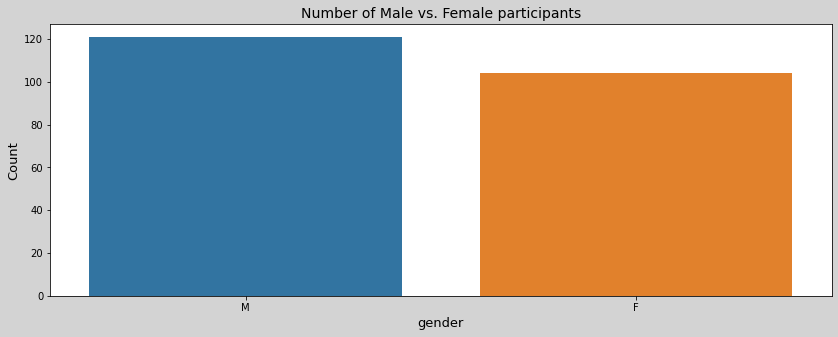

In [24]:
fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='lightgrey')
ax = sns.barplot(x='gender', y='user_counts', data = gender_count.toPandas())
#plt.bar(x='gender', height='user_counts',  width=0.5, color='salmon',data=gender_count.toPandas())

plt.title("Number of Male vs. Female participants", fontsize=14)
plt.xlabel('gender', fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.show()

### 3. How does the `itemInSession` used up by different users?

In [25]:
df_cleaned.select('ItemInSession').describe().collect()

[Row(summary='count', ItemInSession='278154'),
 Row(summary='mean', ItemInSession='114.89918174824018'),
 Row(summary='stddev', ItemInSession='129.85172939948959'),
 Row(summary='min', ItemInSession='0'),
 Row(summary='max', ItemInSession='1321')]

In [26]:
df_cleaned.groupBy(['userId', 'level']).agg(F.mean('itemInSession'),F.max('itemInSession'), F.count('itemInSession')).show(5)

+------+-----+------------------+------------------+--------------------+
|userId|level|avg(itemInSession)|max(itemInSession)|count(itemInSession)|
+------+-----+------------------+------------------+--------------------+
|100021| free| 64.66771159874608|               185|                 319|
|200021| free|44.287553648068666|               104|                 233|
|200001| free|24.930379746835442|                67|                 158|
|     6| free|16.547619047619047|                46|                  84|
|300022| paid|  42.7219730941704|               137|                 446|
+------+-----+------------------+------------------+--------------------+
only showing top 5 rows



In [27]:
df_cleaned.select(['itemInSession']).agg(F.round(F.mean('itemInSession'),2)).show()

+----------------------------+
|round(avg(itemInSession), 2)|
+----------------------------+
|                       114.9|
+----------------------------+



`item-in-Session: ` In average the mean `itemInSessions` was 115 minutes time frame among different users.

### 4. `Average song length by usersId's in seconds?`

In [28]:
song_session_average = spark.sql('''
                        SELECT userId, ROUND(avg(length),2) AS song_session
                        FROM  df_local_view
                        GROUP BY userId
                        ORDER BY song_session DESC
''')
song_session_average.show(3)

+------+------------+
|userId|song_session|
+------+------------+
|200001|      267.77|
|   102|      267.27|
|    63|      266.11|
+------+------------+
only showing top 3 rows



In [29]:
df_cleaned.groupBy(['userId', 'level']).agg(F.mean('length'),F.max('length'), F.count('length')).show(4)

+------+-----+------------------+-----------+-------------+
|userId|level|       avg(length)|max(length)|count(length)|
+------+-----+------------------+-----------+-------------+
|100021| free|250.57902452173911|  563.35628|          230|
|200021| free|247.24942137142867|  591.96036|          175|
|200001| free|267.76714199999986|  1400.2673|          115|
|     6| free|256.77808180327867|  655.77751|           61|
+------+-----+------------------+-----------+-------------+
only showing top 4 rows



In [30]:
df_cleaned.select(['length']).agg(F.round(F.mean('length'),2)).show()
print('Average length of a song is about ( 249.12/60) = 4.15 minutes ')

+---------------------+
|round(avg(length), 2)|
+---------------------+
|               249.12|
+---------------------+

Average length of a song is about ( 249.12/60) = 4.15 minutes 


Text(0, 0.5, 'Session distribution')

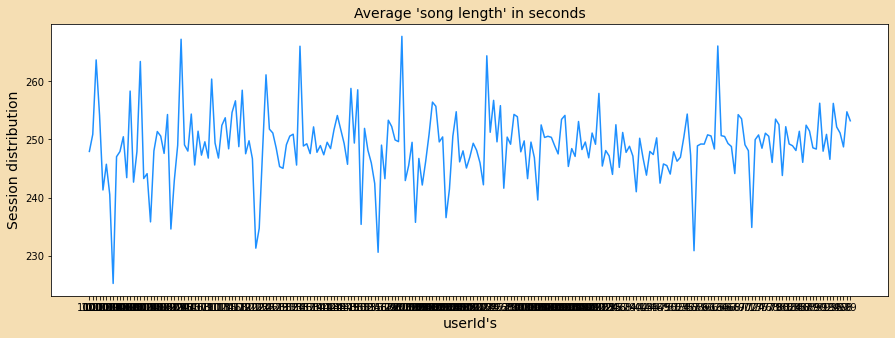

In [31]:
fig, ax = plt.subplots(figsize=(15, 5), edgecolor='k', facecolor='wheat')
ax = sns.lineplot(x='userId', y='song_session', color='dodgerblue',data = song_session_average.toPandas())

plt.title("Average 'song length' in seconds", fontsize=14)
plt.xlabel("userId's", fontsize=14)
plt.ylabel("Session distribution", fontsize=14)

`Song lengths:` It seems average song length fluctuates in between 230 to 300 seconds.

### 5. `Level of subscription type`

In [37]:
user_level_counts = spark.sql('''
                        SELECT level, COUNT(DISTINCT userId) AS user_level_counts
                        FROM  df_local_view
                        GROUP BY level
                        ORDER BY user_level_counts DESC
''')
user_level_counts.show()

+-----+-----------------+
|level|user_level_counts|
+-----+-----------------+
| free|              195|
| paid|              165|
+-----+-----------------+



Text(0, 0.5, 'level distribution')

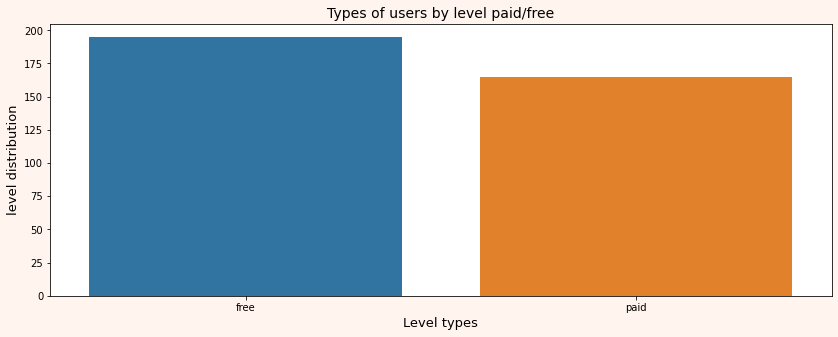

In [38]:
fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='seashell')
ax = sns.barplot(x='level',y='user_level_counts',data=user_level_counts.toPandas());
plt.title("Types of users by level paid/free", fontsize=14)
plt.xlabel("Level types", fontsize=13)
plt.ylabel("level distribution", fontsize=13)

- There are `195 free` and `165 paid` account in this dataset, in another way, there are `135 users` have changed their user-accounts level of subscription.

### 6. `How does the Gender + level distribution looks.`

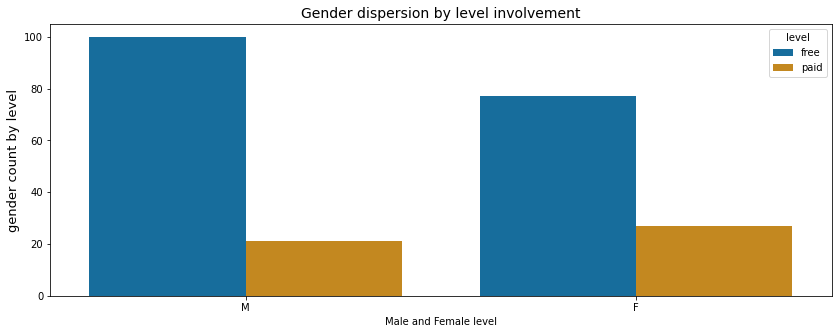

In [39]:
fig, ax = plt.subplots(figsize=(14,5))
gender_level = df.dropDuplicates(['userId']).select(['gender','level','userId']).\
                                     groupby('gender','level').count().sort('gender', ascending=False).toPandas()


sns.barplot(x='gender', y='count', hue='level', data=gender_level, palette='colorblind')
plt.title('Gender dispersion by level involvement', fontsize=14)
plt.xlabel('Male and Female level')
plt.ylabel('gender count by level', fontsize=13)
fig.savefig("gender_level.jpg", bbox_inches='tight')

`Summary visual: ` There are more men on `free tier` than women and conversely more women in `paid plan`

### 7. `What are the City locations our users mostly coming from?`

In [40]:
user_location_count = spark.sql('''
        SELECT location, COUNT(userId) AS user_counts
        FROM  df_local_view
        GROUP BY location
        ORDER BY user_counts DESC
        LIMIT 35      
''').toPandas()

In [41]:
user_location_count.head(3)

,location,user_counts
0,"Los Angeles-Long Beach-Anaheim, CA",30131
1,"New York-Newark-Jersey City, NY-NJ-PA",23684
2,"Boston-Cambridge-Newton, MA-NH",13873


In [42]:
# split location by city and state
user_location_count = user_location_count.join(user_location_count['location'].str.split(',',expand=True).\
                                     rename(columns={0:'city',1:'state'})).drop('location',axis=1)

In [43]:
user_location_count.head()

,user_counts,city,state
0,30131,Los Angeles-Long Beach-Anaheim,CA
1,23684,New York-Newark-Jersey City,NY-NJ-PA
2,13873,Boston-Cambridge-Newton,MA-NH
3,9499,Houston-The Woodlands-Sugar Land,TX
4,7780,Charlotte-Concord-Gastonia,NC-SC


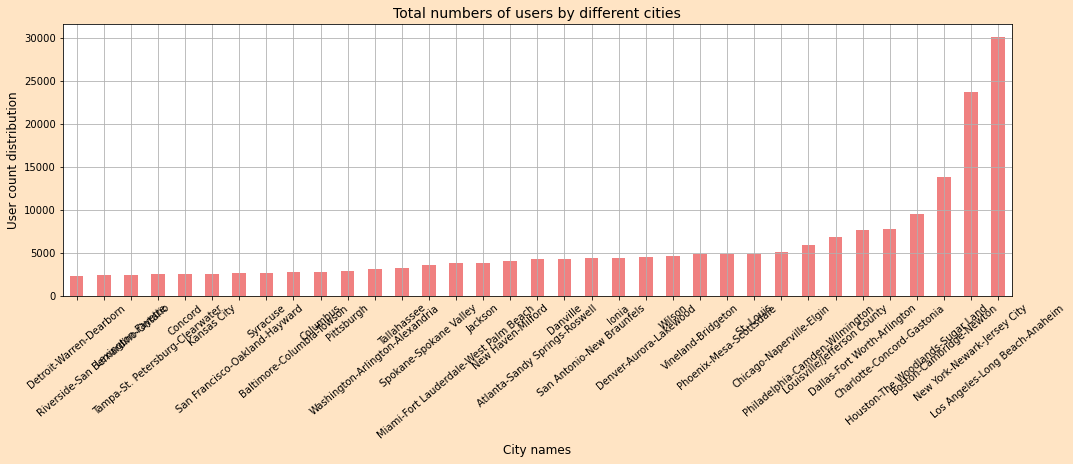

In [44]:
fig, ax = plt.subplots(figsize=(10, 5), edgecolor='k', facecolor='bisque')
ax = user_location_count.sort_values("user_counts", ascending=True).set_index("city")["user_counts"].\
                    plot(kind="bar",figsize=(17,5), color='lightcoral')

plt.title("Total numbers of users by different cities", fontsize=14)
plt.xlabel("City names", fontsize=12)
plt.xticks(rotation=40)
plt.ylabel("User count distribution", fontsize=12)
plt.grid(True)

> Obviously, `Los Angeles, New York, Boston and Houstons` are the top cities which have the largest user counts and the rest of the cities have diminished representation.

### 8. `State wise User distribution?`

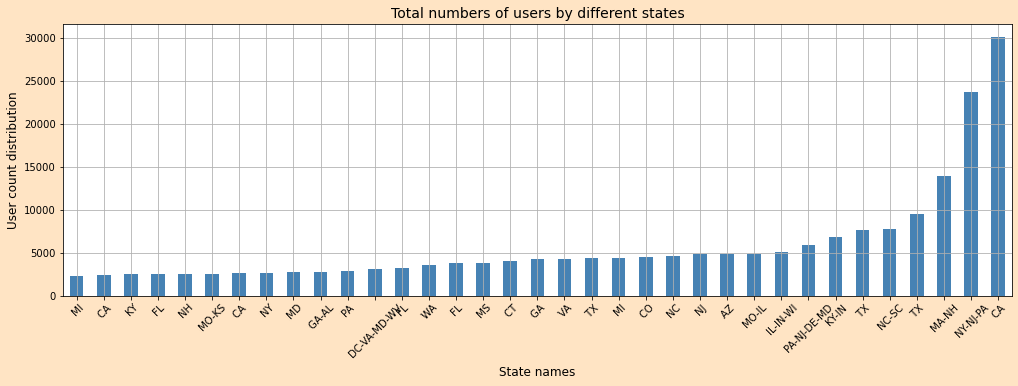

In [45]:
fig, ax = plt.subplots(figsize=(10, 5), edgecolor='k', facecolor='bisque')
ax = user_location_count.sort_values("user_counts", ascending=True).set_index("state")["user_counts"].\
                    plot(kind="bar",figsize=(17,5), color='steelblue')

plt.title("Total numbers of users by different states", fontsize=14)
plt.xlabel("State names", fontsize=12)
plt.ylabel("User count distribution", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

We can see that users' are coming from various places from across the united states, but mostly the south-west such as California, Texas.

- The view is partially minimized with 35 city and states. We see that after the 10th city or state the usage trend goes downward consistently not a great trajectory to analyze.

### 9. `Number of Songs played by each user In average and In total`

In [46]:
total_song_count = df.select(['userId', 'song']).dropDuplicates().groupby(['userId']).count().orderBy('userId')
total_song_count.describe().show()
print('Total song played by all users: ')

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|               226|              226|
|   mean|65391.013333333336|894.8141592920354|
| stddev| 105396.4779190716|896.3894099099026|
|    min|                  |                1|
|    max|                99|             5947|
+-------+------------------+-----------------+

Total song played by all users: 


In [47]:
userId_song = df.select(['userId', 'song']).dropDuplicates().groupby(['userId']).count().orderBy('userId')
print('Song played by each user: ', userId_song.show(6))

+------+-----+
|userId|count|
+------+-----+
|      |    1|
|    10|  630|
|   100| 2303|
|100001|  130|
|100002|  194|
|100003|   52|
+------+-----+
only showing top 6 rows

Song played by each user:  None


In [48]:
total_song_count = df.select(['userId', 'song']).dropDuplicates().groupby(['userId']).count().orderBy('userId')
print('Average song listened by each user in all session:')
total_song_count.agg({'count':'avg'}).withColumnRenamed("avg(count)","mean_song_listened").show()

Average song listened by each user in all session:
+------------------+
|mean_song_listened|
+------------------+
| 894.8141592920354|
+------------------+



`Findings: `So average user have listened 895 songs in average

### 10. `Number of song played by each user on each session:`

In [49]:
song_per_session1 = df.filter(df.page == 'NextSong').groupby(['userId','sessionId']).count()
song_per_session2 = song_per_session1.groupby('userId').agg({'count':'avg'})
song_per_session2 = song_per_session2.select('userId', round(col('avg(count)'),2))
song_per_session2 = song_per_session2.withColumnRenamed("round(avg(count), 2)", "mean_song_played")
print("Song played by users in each sessions:")
song_per_session2.show(5)

Song played by users in each sessions:
+------+----------------+
|userId|mean_song_played|
+------+----------------+
|100010|           39.29|
|200002|            64.5|
|   125|             8.0|
|    51|           211.1|
|   124|          145.68|
+------+----------------+
only showing top 5 rows



In [50]:
song_per_session2.select('mean_song_played').describe().show()
print('Each users played in average 71 songs in each session:' )

+-------+----------------+
|summary|mean_song_played|
+-------+----------------+
|  count|             225|
|   mean|70.7897777777778|
| stddev|42.6154802046791|
|    min|             3.0|
|    max|          286.67|
+-------+----------------+

Each users played in average 71 songs in each session:


### 11. `Total and average number of artist played by each user:`

In [51]:
Num_artist_played_by_session = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count()
Num_artist_played_by_session.show(3)

+------+-----+
|userId|count|
+------+-----+
|100010|  253|
|200002|  340|
|   125|    9|
+------+-----+
only showing top 3 rows



In [52]:
print('Descriptive statistics of the artists: ')
Num_artist_played_by_session.select('count').describe().show()
print('Each users have played in average 694 artists.')

Descriptive statistics of the artists: 
+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              226|
|   mean|  694.29203539823|
| stddev|604.3910901823741|
|    min|                1|
|    max|             3545|
+-------+-----------------+

Each users have played in average 694 artists.


### 12. `Song session by each sessionId and by each user on hourly basis:`

In [53]:
df_cleaned_copy = df_cleaned.select("*")

In [54]:
session_end_time = df_cleaned_copy.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'endTime')
session_start_time = df_cleaned_copy.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'starTime')

In [55]:
# joining both sessions
session_combined = session_end_time.join(session_start_time, ['userId', 'sessionId'])
#session_combined.show(3)

# 1000 * 60 * 60 = 3600000 milliseconds to 1 hour
ticks_per_hours =  1000 * 60 * 60   # hourly ticks
# creating new column
session_combined = session_combined.withColumn("total_session_time", (session_combined.endTime - session_combined.starTime)/(ticks_per_hours))
# renaming new column
session_combined = session_combined.select("userId", "sessionId", round('total_session_time',2)).\
                                            withColumnRenamed("round(total_session_time, 2)","session_time")
print("Each user by respective total session and hourly time spend: ")
session_combined.show(5)

Each user by respective total session and hourly time spend: 
+------+---------+------------+
|userId|sessionId|session_time|
+------+---------+------------+
|   101|      635|        55.0|
|   110|     1776|        1.39|
|   120|      627|       15.86|
|   122|      691|        0.31|
|   140|      798|        0.16|
+------+---------+------------+
only showing top 5 rows



Text(0.5, 1.0, 'SessionId and time usage by each userIds')

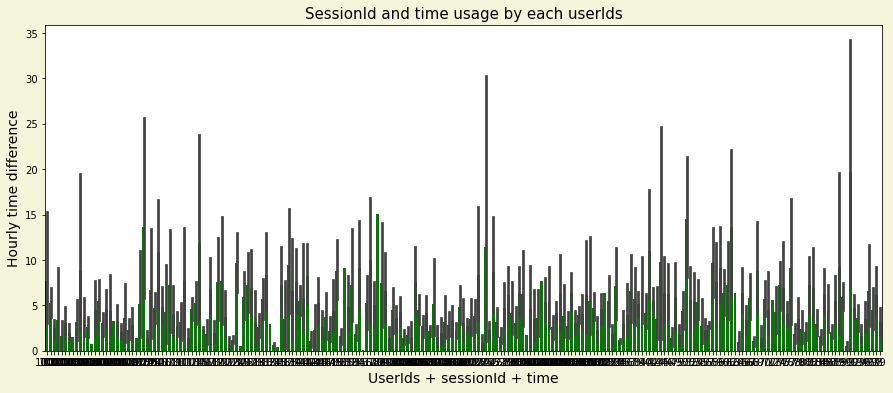

In [56]:
fig, ax = plt.subplots(edgecolor='m', facecolor='beige',figsize=(15,6))                                                                                            
sns.barplot(x='userId', y='session_time', data= session_combined.toPandas(), color='g')
ax.set_xlabel("UserIds + sessionId + time", fontsize = 14)
ax.set_ylabel("Hourly time difference", fontsize=14)
ax.set_title("SessionId and time usage by each userIds", fontsize=15)

### 13. `Amount of time spent by each user on each session by hours:`

In [57]:
df_session = df_cleaned.select("*")

In [58]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%H"))

#Apply the udf on the ts column
df_session = df_session.withColumn("Hours", get_time(df_session.ts))

In [59]:
df_session.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Hours='17')]

### 14.a `Total Hour  spent by each user`

In [60]:
user_total_hour = df_session.select(['userId', 'Hours']).dropDuplicates().\
                                             groupby(['userId']).agg({'Hours':'sum'})
# renaming 'minutes' to 'session_minutes'
user_total_hour = user_total_hour.withColumnRenamed('sum(Hours)', 'Total_Hours').orderBy('userId')
user_total_hour.show(7)

+------+-----------+
|userId|Total_Hours|
+------+-----------+
|    10|      276.0|
|   100|      276.0|
|100001|      124.0|
|100002|      169.0|
|100003|       30.0|
|100004|      276.0|
|100005|       93.0|
+------+-----------+
only showing top 7 rows



### 14.b `All users with total number of session + total amount of hours with each sessions`

In [61]:
# Grouping all users' with total number of sessios + total amount of in all sessions
user_session_hours = df_session.select(['userId', 'sessionId', 'Hours']).dropDuplicates().\
                                             groupby(['userId', 'sessionId']).agg({'Hours':'sum'})

user_session_hours = user_session_hours.withColumnRenamed('sum(Hours)', 'session_Hours').orderBy('userId')

user_session_hours = user_session_hours.select(['userId', 'sessionId', 'session_Hours']).dropDuplicates().\
                                                    groupby('userId').sum().orderBy('userId')
user_session_hours.show(5)

+------+--------------+------------------+
|userId|sum(sessionId)|sum(session_Hours)|
+------+--------------+------------------+
|    10|          6638|             571.0|
|   100|         50421|            2393.0|
|100001|           151|             147.0|
|100002|           496|             232.0|
|100003|            89|              38.0|
+------+--------------+------------------+
only showing top 5 rows



In [62]:
print('Shape of this dataset: ', user_session_hours.count(),'rows and', len(user_session_hours.columns), 'columns')

Shape of this dataset:  225 rows and 3 columns


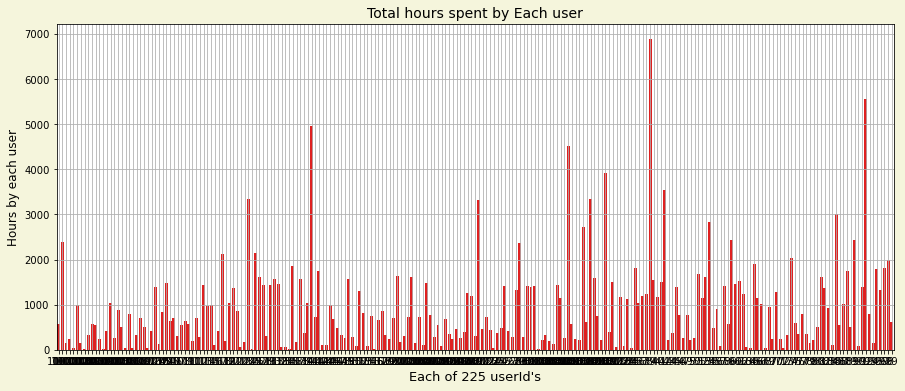

In [63]:
fig, ax = plt.subplots(edgecolor='m', facecolor='beige',figsize=(15,6))                                                                                            
sns.barplot(x='userId', y='sum(session_Hours)', data=user_session_hours.toPandas(), color='r')
plt.title("Total hours spent by Each user", fontsize=14)
plt.xlabel("Each of 225 userId's", fontsize=13)
plt.ylabel("Hours by each user", fontsize=12)
plt.grid(True)

In [64]:
#print((df.count(), len(df.columns)))
#df.count()
#row_number = data.count()
#column_number = len(data.dtypes)

## `Defining user Churn:`

Here we will redefine 'Cancellation Confirmation' page as the churning column, which will contain values '1' for `churn` and '0' for `remained` or `not churned`. We will use this column as a  major source of target to investigate out what are the critical reasons of customer churning out of the music streaming service.

> We will be subselecting datasets involved with churned data distribution and display critical findings in multiple graphs as we progress through the note book.

In [65]:
# Churn is a label for user who cancelled
cancelled = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df_cleaned_churned = df_cleaned.withColumn("churn", cancelled(df_cleaned.page))

#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df_cleaned_churned = df_cleaned_churned.withColumn("churn", Fsum("churn").over(windowval))

In [66]:
df_cleaned_churned.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0)]

In [67]:
df_cleaned_churned.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [68]:
#df_cleaned_churned.toPandas().drop_duplicates('userId').groupby(['churn'])['churn'].count()

###  `Statistical significance test of Chruning with Z-test:`

source: https://www.dummies.com/education/math/statistics/how-to-set-up-a-hypothesis-test-null-versus-alternative/

`LEVEL AND CHURNING`

- statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None,
                                               alternative='two-sided', prop_var=False)
                                               
- count =  the number of `successes/target` for each independent sample
- nobs (integer or array-like) – the number of `trials/observations`, with the same length as count.

Let's set our `null hypothesis` is `"Paid or free service is not effecting users churning behavior"` that follows our `alternative hypothesis` is `"Free users were churning more than Paid users"`.

In [69]:
df_cleaned_churned.dropDuplicates(['userId']).select(['level','churn','userId']).\
                                     groupby('level','churn').count().sort('level', ascending=False).collect()

[Row(level='paid', churn=0, count=40),
 Row(level='paid', churn=1, count=8),
 Row(level='free', churn=0, count=133),
 Row(level='free', churn=1, count=44)]

In [70]:
count = np.array([44, 8])     # the number of successes in number of trials
nobs = np.array([177, 48])    # total number of trials or observations

In [71]:
stat, pval = proportions_ztest(count, nobs)

In [72]:
print('Test static is: {0:0.3f}'.format(stat))

Test static is: 1.194


In [73]:
print('P-value is: {0:0.3f}'.format(pval))

P-value is: 0.232


**`Free-Paid service effect on churning:`** 

- Our p-value is `0.23` > `0.05` is higher than standard `0.05`, on which findings we cannot rejects the null hypothesis that 'Paid' users are churning more than 'free' users.

- Our `Z test-statics` is `1.19` which is smaller than `1.96`, so we cannot `reject` the `null hypothesis`. 
  
- So our null hypothesis is not statistically significant and I can say that `free/paid` services does not influences users churning behavior.

## `User Churn effect on features:`

- A detail visual analysis of how `churning` progresses with `level` an `Gender` features.

In [74]:
df_panda = df_cleaned_churned.toPandas() # Converting newly changed dataset to a pandas dataset for better visual

### 1. `Gender  and churning spread`

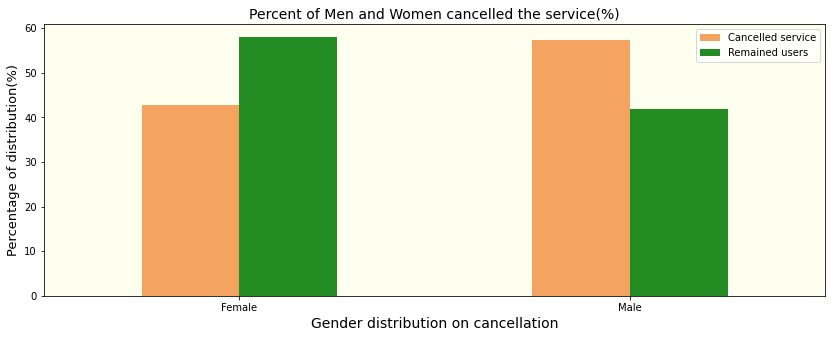

In [75]:
# users who churned and used pages
users_1 = df_panda[df_panda.churn == 1].groupby(['gender'])['userId'].count() 
users_1 = users_1 /users_1.sum()*100

# users who didn't cancel but navigated pages
users_0 = df_panda[df_panda.churn == 0].groupby(['gender'])['userId'].count() 
users_0 = users_0 /users_0.sum()*100

# plotting
users_df = pd.DataFrame({'Cancelled service': users_1,'Remained users':users_0})

#fig, ax = plt.subplots(figsize=(14,5))
ax = users_df.plot(kind='bar',color=('sandybrown','forestgreen'),figsize=(14,5));
ax.set_facecolor('ivory')
ax.set_title('Percent of Men and Women cancelled the service(%)',fontsize = 14);
ax.set_ylabel('Percentage of distribution(%)',fontsize = 13);
ax.set_xlabel('Gender distribution on cancellation', fontsize = 14);
ax.set_xticklabels(['Female','Male'], rotation=0);

fig.savefig("gender_based_chunred.jpg", bbox_inches='tight')

### 2. `Gender + level + churning in detail`

In [76]:
# Male-Female churned Paid and Free level
df_cleaned_churned.dropDuplicates(['userId']).groupby(['gender','churn']).count().sort('gender', ascending=False).show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     M|    0|   89|
|     F|    1|   20|
|     F|    0|   84|
+------+-----+-----+



In [77]:
# More detail in paid and free service...
df_cleaned_churned.dropDuplicates(['userId']).groupby(['gender','level','churn']).count().sort('level', ascending=False).show()

+------+-----+-----+-----+
|gender|level|churn|count|
+------+-----+-----+-----+
|     F| paid|    1|    3|
|     M| paid|    1|    5|
|     F| paid|    0|   24|
|     M| paid|    0|   16|
|     F| free|    1|   17|
|     F| free|    0|   60|
|     M| free|    0|   73|
|     M| free|    1|   27|
+------+-----+-----+-----+



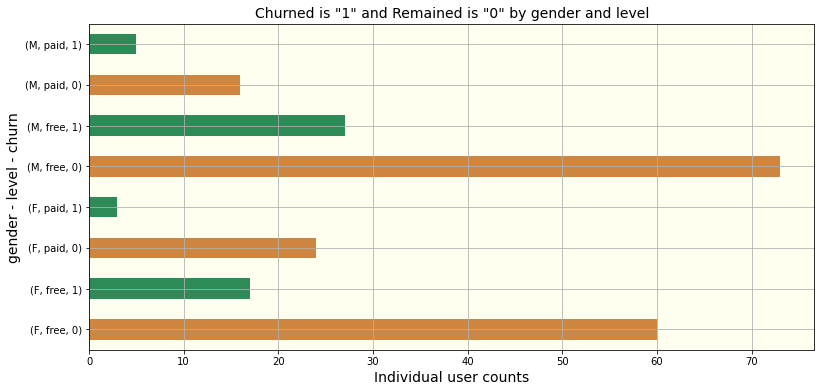

In [78]:
ax = df_cleaned_churned.toPandas().drop_duplicates(['userId']).groupby(['gender','level','churn'])['churn'].count().\
                              plot(kind='barh', figsize=(13,6), color=('peru','seagreen'))

ax.set_facecolor("ivory") 
plt.title('Churned is "1" and Remained is "0" by gender and level',fontsize=14)
plt.xlabel('Individual user counts', fontsize=14)
plt.ylabel('gender - level - churn', fontsize=14)
plt.grid()

`Summary analysis : `

We can see that more `Male-Free` customers churned than `Female-free` customers. On the contrary, more `Male-Paid` users churned than `Women-Paid` customers. Overall in both `Paid-Free` customer category more `Male` customer unsubscribe than `Female`.

### 3. `Percentile projection of churning with gender and level involved`

Text(0, 0.5, 'Percentile occurence (%)')

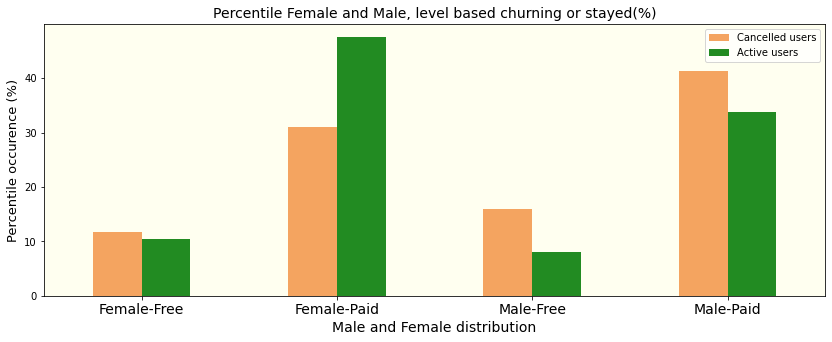

In [79]:
users_1 = df_panda[df_panda.churn == 1].groupby(['gender','level'])['userId'].count().sort_values(ascending=True)
# calculating percentage of users
users_1 = users_1 /users_1.sum()*100

users_0 = df_panda[df_panda.churn == 0].groupby(['gender','level'])['userId'].count().sort_values(ascending=True)
# percentage of users
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Cancelled users': users_1,'Active users':users_0})

# plotting elements
ax = users_df.plot(kind='bar', figsize=(14,5), color=('sandybrown','forestgreen'));
ax.set_facecolor('ivory')

ax.set_title('Percentile Female and Male, level based churning or stayed(%)', fontsize=14);
ax.set_xlabel('Male and Female distribution', fontsize=14)
plt.xticks(rotation=0, horizontalalignment='center', fontweight='light', fontsize=14)
ax.set_xticklabels(['Female-Free','Female-Paid', 'Male-Free', 'Male-Paid'], rotation=0);

ax.set_ylabel('Percentile occurence (%)', fontsize=13)

### 4. `Non-Percentile Gender and level distribution with churning behavior`

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

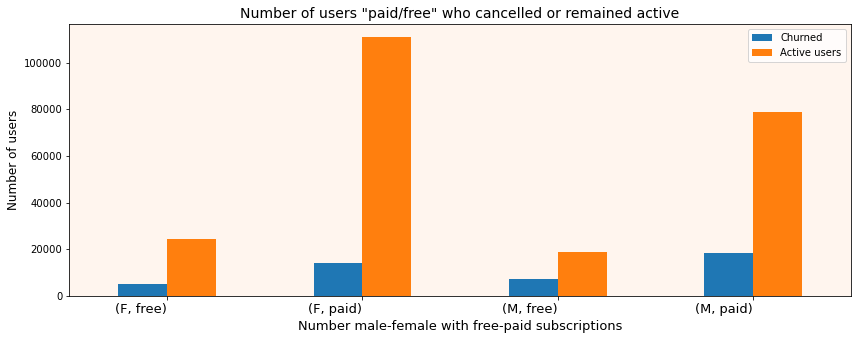

In [80]:
# gender and level with churning is true
users_1 = df_panda[df_panda.churn == 1].groupby(['gender','level'])['userId'].count().sort_values(ascending=True)
# gender and level with churning not tru
users_0 = df_panda[df_panda.churn == 0].groupby(['gender','level'])['userId'].count().sort_values(ascending=True)
#  inplacing in a data frame
users_df = pd.DataFrame({'Churned': users_1,'Active users':users_0})

# drawing the plot
ax = users_df.plot(kind='bar', figsize=(14,5));
ax.set_facecolor('seashell')

ax.set_xlabel('Number male-female with free-paid subscriptions', fontsize = 13)
ax.set_ylabel('Number of users', fontsize=12)
ax.set_title('Number of users "paid/free" who cancelled or remained active', fontsize=14)
plt.xticks(rotation=0, horizontalalignment='right', fontweight='light', fontsize=13)

`Visual analyses: ` This projection is a non-percentile churning involved with `level + gedner + churning`. To compare I can say that `Percentile visualization` offers a better comparative picture of `cancellation and staying` with the serivce than non-percentile one.

## `Page usage pattern in details: `

Considering this is an online music subscription service, different web page attributes carries users online usage behavior. By analyzing these page-related behavior I will try to extract out a distinct perspective about customer turn overs. Here we will visualize some of the cutomer subscription related trends, patterns and their effects of cancelling the musice serivce. I used commonsense approach to describe how these pages were designed for this digital service.

> In our assigned project we're primarily concerned about what are the reasons existing customers are  churning out of the    music service. This concern involves a business decision making process. We know by questioning underlying reasons of a business problem we can scrape out better reasoning to solve the problem. In that persuasion I'll be asking these underlying questions about how churning is evolving with this streaming service. These searchings are mainly related to customer behavior patterns and usage trends.

A. Was that lot of customers were asking for help with number of complaints?

B. Has any existing customer's usage has dropped drastically lately?
 
C. Is 'thumbs down' is a precursor of cancelling the service?

B. Was there lot of page errors are causing customers to leave the service?

C. Do existing customer tend to leave the service when their friends unsubscribe?

D. Paid or free customers who is leaving more in number and why?

E. Is total music play time is a factor influencing their decision to leave the service?

F. Adding more song to playlist affects users' decsion not to unsubscribe?

G. Does more thumbsUp means not churning out of the service?

### `Page descriptions in summary:`

**`Page sub-category attributes descriptions`**


`About: `   - Information in detail about the song services

`Add Friend` - Number of friends added while using the service

`Add to Playlist` - Songs added to users' playlist

`Cancel` - Users who cancelled the subscription

`Cancellation Conf...` - Number of users confirmed the cancellation

`Downgrade` - Number of downgrades by users 

`Error` - Number of error occured while page surfing

`Help` - Number of users searched for help

`Home` - Main page

`Logout` - How many time users logout of the service page

`NextSong` - Song lisenting page

`Roll Advert` - Rolling advertisement while in the page

`Save Settings` - Saving user settings.

`Setting` - Page setting

`Submit Downgrade` - How many users downgraded the service

`Submit Upgrade` - Users who submit upgrade request

`Thumbs Down` - Number of Thumbs down or dislikes by users

`Thumbs Up` - Number of ThumbsUp or likes by users

`Upgrade` - Page upgrade ny numbers

In [81]:
# Quick view of the web-pages by their page-content and users surfing counts
df_cleaned_churned.select('page').groupby('page').count().orderBy('page',ascending=True).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|               About|   495|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|              Cancel|    52|
|Cancellation Conf...|    52|
|           Downgrade|  2055|
|               Error|   252|
|                Help|  1454|
|                Home| 10082|
|              Logout|  3226|
|            NextSong|228108|
|         Roll Advert|  3933|
|       Save Settings|   310|
|            Settings|  1514|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|         Thumbs Down|  2546|
|           Thumbs Up| 12551|
|             Upgrade|   499|
+--------------------+------+



## `Page feature distribution and visualization Snapshot:`

> Page is a very consequential column in analyzing the whole PySpark project. I will do a detail analyses in a bit later down.
  But here I'm just introducing all the available page features to its users.

### 1. Page distribution by `page_usage_counts`

In [82]:
page_uage_counts = spark.sql('''
                       SELECT page,COUNT(userId) AS page_counts
                       FROM  df_local_view
                       GROUP BY page
                       ORDER BY page_counts DESC
''').toPandas()
page_uage_counts

,page,page_counts
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


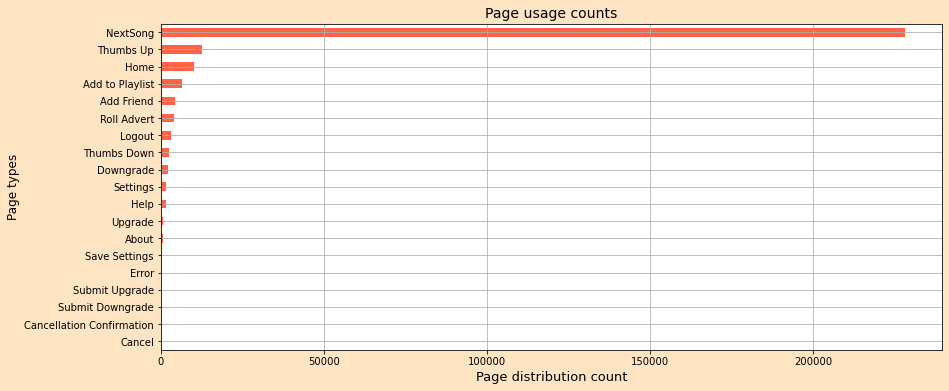

In [83]:
page_count = df_cleaned.groupby("page").count()

fig, ax = plt.subplots(edgecolor='g', facecolor='bisque')
page_count.toPandas().sort_values(by='count',ascending=True).set_index('page')['count'].plot(kind='barh', color='tomato',\
                                                                                             figsize=(14,6))
plt.title("Page usage counts", fontsize=14)
plt.xlabel("Page distribution count", fontsize=13)
plt.ylabel("Page types", fontsize=12)
plt.grid(True)

### 2. `Page distribution by user_counts`

In [84]:
page_user_counts = spark.sql('''
        SELECT page,COUNT(DISTINCT userId) AS user_counts
        FROM  df_local_view
        GROUP BY page
        ORDER BY user_counts DESC
''').toPandas()

page_user_counts

,page,user_counts
0,NextSong,225
1,Home,223
2,Thumbs Up,220
3,Add to Playlist,215
4,Logout,213
5,Roll Advert,207
6,Add Friend,206
7,Thumbs Down,203
8,Settings,195
9,Help,192


Text(0, 0.5, 'Page index')

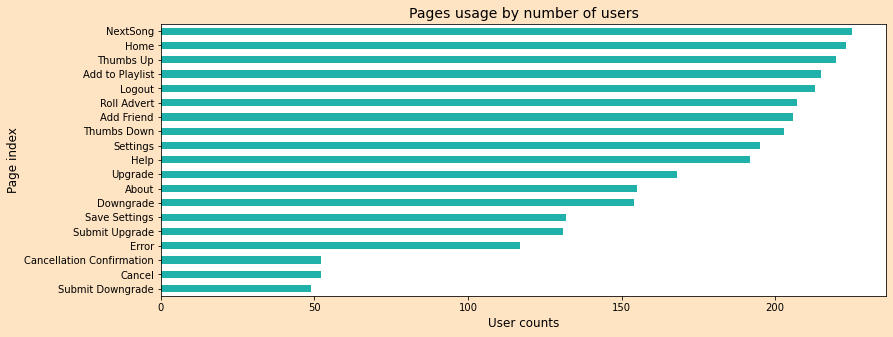

In [85]:
fig, ax = plt.subplots(edgecolor='g', facecolor='bisque')
page_user_counts.sort_values('user_counts').set_index("page")["user_counts"].\
                                                     plot(kind='barh', color='lightseagreen',figsize=(13, 5))
plt.title("Pages usage by number of users", fontsize=14)
plt.xlabel("User counts", fontsize=12)
plt.ylabel("Page index", fontsize=12)

In [86]:
print('Visualizing page by user_counts and usage_counts: \n')
pd.merge(page_user_counts, page_uage_counts, on=['page'], how='inner', validate='one_to_one')

Visualizing page by user_counts and usage_counts: 



,page,user_counts,page_counts
0,NextSong,225,228108
1,Home,223,10082
2,Thumbs Up,220,12551
3,Add to Playlist,215,6526
4,Logout,213,3226
5,Roll Advert,207,3933
6,Add Friend,206,4277
7,Thumbs Down,203,2546
8,Settings,195,1514
9,Help,192,1454


**`PAGE USAGE AND SNAPSHOT ANALYSES:`**

- We can see that out of roughly 225 registered users of which 52 of them end up cancelling the service and around 50
  downgraded their service. 
  
- We can see from this graph that users tend to use the service mostly for playing music also they visits the home button a lot
  of times to rate music that they like.

- Home page counts the second largest visits.

- There are lots of `thumbsUp`, `Add Friend`, `Add to Playlist`, `Roll Advert` usage is visual.

- There is a large number of 'downgrade' is also present.

- We can see that `cancel` and `cancellation confirmations` are the same numbers and meanings.

## `Page-distribution effect on users churning:`

> I've dropped `NextSong page` from total page count, since it has the highest visiting average ( 228,108 /225 = 1013.81) by each users.It keeps tab everytime an user plays a song, which has the `potential of skewing` the oveall page visitng distribution.

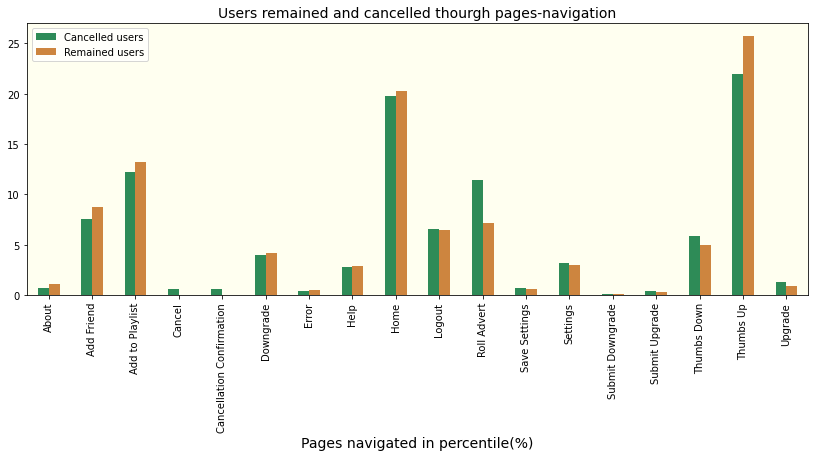

In [87]:
# users who churned and used pages
users_1 = df_panda[df_panda.churn == 1].groupby(['page'])['userId'].count().drop('NextSong').sort_values(ascending=False)
users_1 = users_1 /users_1.sum()*100

# users who didn't cancel but navigated pages
users_0 = df_panda[df_panda.churn == 0].groupby(['page'])['userId'].count().drop('NextSong').sort_values(ascending=False)
users_0 = users_0 /users_0.sum()*100

# plotting
users_df = pd.DataFrame({'Cancelled users': users_1,'Remained users':users_0})
ax = users_df.plot(kind='bar', figsize=(14,5), color=("seagreen","peru"));
ax.set_facecolor('ivory')
ax.set_xlabel('Pages navigated in percentile(%)',fontsize = 14);
ax.set_title('Users remained and cancelled thourgh pages-navigation', fontsize = 14);

> We can see that pages....`'Roll Advert', 'Thumbs Down', 'Upgrade' and 'Settings'` are causing `more churning out` than other 
  pages.

> It is obvious that pages like `Add Friend`, `Add to Playlist`,`Downgrade`,`Home`, `Help`,`ThumbsUp` are keeping users with the service more.

###  `Page attribute related churning behavior analyses with 'Scatterplot'`

How users left their markings on churning while navigating different pages can be very clearly visual in these 6 different scatterplots. These scatter plots offers true visualization how churning evolved with page usage.

### 1. `Number of friends added in correlation with cancellation.`

In [88]:
# Find song long time correlation w/ cancellation
Friends_vs_Cancellation = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_cancelled,
           SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END) AS Num_Friends_Added
    FROM df_local_view
    GROUP BY userId
""").toPandas()

In [89]:
Friends_vs_Cancellation.head(3)

,userId,is_cancelled,Num_Friends_Added
0,100010,0,4
1,200002,0,4
2,125,1,0


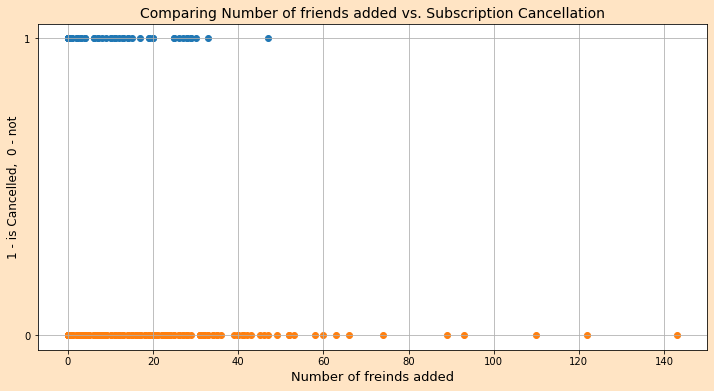

In [90]:
fig, ax = plt.subplots(figsize=(12, 6), edgecolor='k', facecolor='bisque')

plt.scatter(Friends_vs_Cancellation[Friends_vs_Cancellation["is_cancelled"] == 1]["Num_Friends_Added"], 
            Friends_vs_Cancellation[Friends_vs_Cancellation["is_cancelled"] == 1]["is_cancelled"])
#-------------------------------------------------------------------------
plt.scatter(Friends_vs_Cancellation[Friends_vs_Cancellation["is_cancelled"] == 0]["Num_Friends_Added"], 
            Friends_vs_Cancellation[Friends_vs_Cancellation["is_cancelled"] == 0]["is_cancelled"])

plt.yticks((0, 1))
plt.title("Comparing Number of friends added vs. Subscription Cancellation", fontsize = 14)
plt.xlabel("Number of freinds added", fontsize = 13)
plt.ylabel("1 - is Cancelled,  0 - not", fontsize = 12)
plt.grid()

`View anlysis:` We see that `the more` an user adds friend the `the less` the chance that they would `unsubscribe` the service.

### 2. `Add to playlist vs. cancellation.`

In [91]:
addPlayList_to_cancellation = spark.sql("""
                      SELECT userId,
                      MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_cancelled,
                      SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END) AS addPlayList
                      FROM df_local_view
                      GROUP BY userId
""").toPandas()

In [92]:
addPlayList_to_cancellation.head(3)

,userId,is_cancelled,addPlayList
0,100010,0,7
1,200002,0,8
2,125,1,0


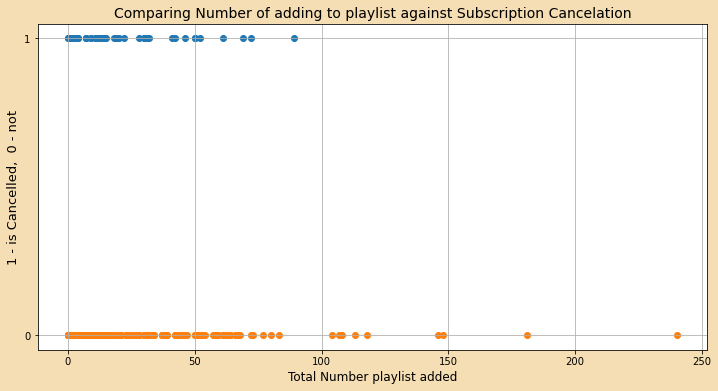

In [93]:
fig, ax = plt.subplots(figsize=(12, 6), edgecolor='b', facecolor='wheat')

plt.scatter(addPlayList_to_cancellation[addPlayList_to_cancellation["is_cancelled"] == 1]["addPlayList"], 
            addPlayList_to_cancellation[addPlayList_to_cancellation["is_cancelled"] == 1]["is_cancelled"])
#-------------------------------------------------------------------------
plt.scatter(addPlayList_to_cancellation[addPlayList_to_cancellation["is_cancelled"] == 0]["addPlayList"], 
            addPlayList_to_cancellation[addPlayList_to_cancellation["is_cancelled"] == 0]["is_cancelled"])

plt.yticks((0, 1))
plt.title("Comparing Number of adding to playlist against Subscription Cancelation", fontsize=14)
plt.xlabel("Total Number playlist added", fontsize=12)
plt.ylabel("1 - is Cancelled,  0 - not", fontsize=13)
plt.grid()

`View summary:` When an user adding more songs in their playlist they tends not to churning out of the service.

### 3. A juxtaposed view of `Add Friend` and `Add to Playlist`

In [94]:
# Find song time in correlation with cancellation
Friend_vs_Playlist = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_cancelled,
           SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END) AS Total_Friend_Added,
           MIN(CASE WHEN page = 'Cancellation Confirmation' THEN 2 ELSE 3 END) AS also_cancelled,
           SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END) AS Total_Playlist_Added
    FROM df_local_view
    GROUP BY userId
""").toPandas()

In [95]:
Friend_vs_Playlist.head(3)

,userId,is_cancelled,Total_Friend_Added,also_cancelled,Total_Playlist_Added
0,100010,0,4,3,7
1,200002,0,4,3,8
2,125,1,0,2,0


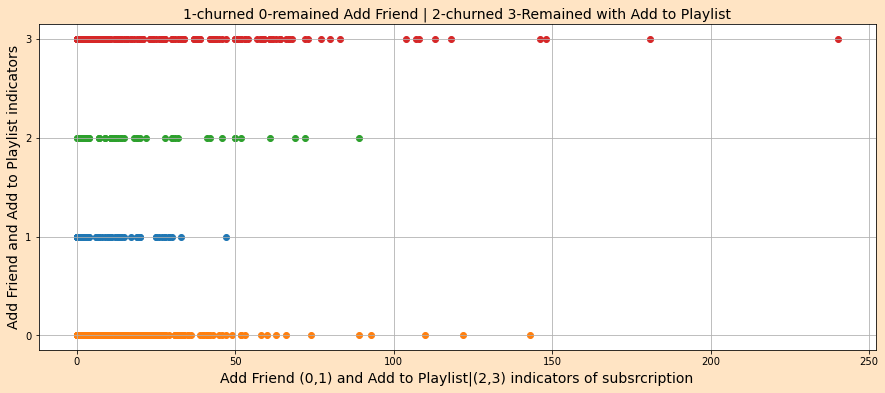

In [96]:
fig, ax = plt.subplots(figsize=(15, 6), edgecolor='b', facecolor='bisque')

plt.scatter(Friend_vs_Playlist[Friend_vs_Playlist["is_cancelled"] == 1]["Total_Friend_Added"],         
            Friend_vs_Playlist[Friend_vs_Playlist["is_cancelled"] == 1]["is_cancelled"])

plt.scatter(Friend_vs_Playlist[Friend_vs_Playlist["is_cancelled"] == 0]["Total_Friend_Added"], 
            Friend_vs_Playlist[Friend_vs_Playlist["is_cancelled"] == 0]["is_cancelled"])
#----------------------------------------------------------------------------------------------------
plt.scatter (Friend_vs_Playlist[Friend_vs_Playlist["also_cancelled"] == 2]["Total_Playlist_Added"], 
             Friend_vs_Playlist[Friend_vs_Playlist["also_cancelled"] == 2]["also_cancelled"])

plt.scatter(Friend_vs_Playlist[Friend_vs_Playlist["also_cancelled"] == 3]["Total_Playlist_Added"], 
            Friend_vs_Playlist[Friend_vs_Playlist["also_cancelled"] == 3]["also_cancelled"])
#-------------------------------------------------------------------------


plt.yticks((0, 1, 2, 3))
plt.title("1-churned 0-remained Add Friend | 2-churned 3-Remained with Add to Playlist", fontsize=14)
plt.xlabel("Add Friend (0,1) and Add to Playlist|(2,3) indicators of subsrcription", fontsize=14)
plt.ylabel("Add Friend and Add to Playlist indicators", fontsize=14)
plt.grid()

`Visual analyses: ` Looking into line `0 and 3` are lot longer than line `1 and 2` indicates pages `Add Friend` and `Add to Playlist` are holding more users with the streaming service.

### 4. `Subscription cancellation` with `thumbs-up` and `thumbs-down` pages

In [97]:
# Find song time in correlation with cancellation
thumbsDown_vs_thumbsUp = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_cancelled,
           SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) AS Total_Thumbs_Down,
           MIN(CASE WHEN page = 'Cancellation Confirmation' THEN 2 ELSE 3 END) AS also_cancelled,
           SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) AS Total_Thumbs_Up
    FROM df_local_view
    GROUP BY userId
""").toPandas()

In [98]:
thumbsDown_vs_thumbsUp.head(3)

,userId,is_cancelled,Total_Thumbs_Down,also_cancelled,Total_Thumbs_Up
0,100010,0,5,3,17
1,200002,0,6,3,21
2,125,1,0,2,0


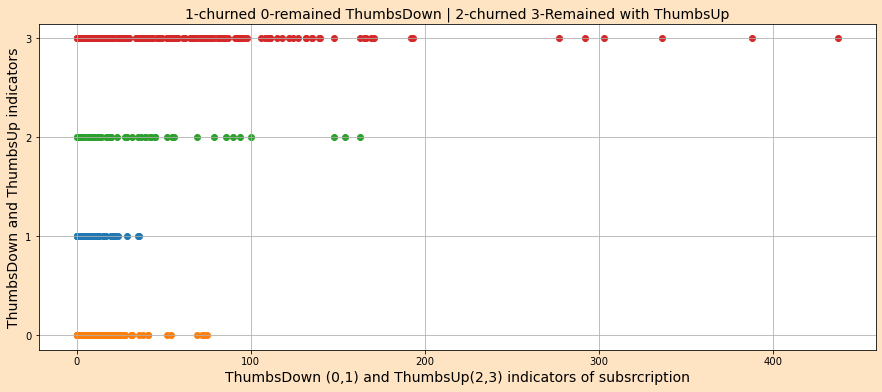

In [99]:
fig, ax = plt.subplots(figsize=(15, 6), edgecolor='b', facecolor='bisque')

plt.scatter(thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["is_cancelled"] == 1]["Total_Thumbs_Down"],         
            thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["is_cancelled"] == 1]["is_cancelled"])

plt.scatter(thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["is_cancelled"] == 0]["Total_Thumbs_Down"], 
            thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["is_cancelled"] == 0]["is_cancelled"])
#----------------------------------------------------------------------------------------------------
plt.scatter (thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["also_cancelled"] == 2]["Total_Thumbs_Up"], 
             thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["also_cancelled"] == 2]["also_cancelled"])

plt.scatter(thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["also_cancelled"] == 3]["Total_Thumbs_Up"], 
            thumbsDown_vs_thumbsUp[thumbsDown_vs_thumbsUp["also_cancelled"] == 3]["also_cancelled"])
#-------------------------------------------------------------------------


plt.yticks((0, 1, 2, 3))
plt.title("1-churned 0-remained ThumbsDown | 2-churned 3-Remained with ThumbsUp", fontsize=14)
plt.xlabel("ThumbsDown (0,1) and ThumbsUp(2,3) indicators of subsrcription", fontsize=14)
plt.ylabel("ThumbsDown and ThumbsUp indicators", fontsize=14)
plt.grid()

`Findings:` Obviously `thumbsUp` lines (2,3) is holding more users with the service however `thumbsDown`line(0,1) is not causing lot more churning out of the service either. It is not an alarming attrition with the `thumbsDown` page.

### 5. `Subscription cancellation with page - error and Help`

In [100]:
Page_error_help = spark.sql("""
           SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_cancelled,
           SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS total_page_error,
           MIN(CASE WHEN page = 'Cancellation Confirmation' THEN 2 ELSE 3 END) AS also_cancelled,
           SUM(CASE WHEN page = 'Help' THEN 1 ELSE 0 END) AS total_help_needed
    FROM df_local_view
    GROUP BY userId
                      
""").toPandas()

In [101]:
Page_error_help.head(3)

,userId,is_cancelled,total_page_error,also_cancelled,total_help_needed
0,100010,0,0,3,2
1,200002,0,0,3,2
2,125,1,0,2,0


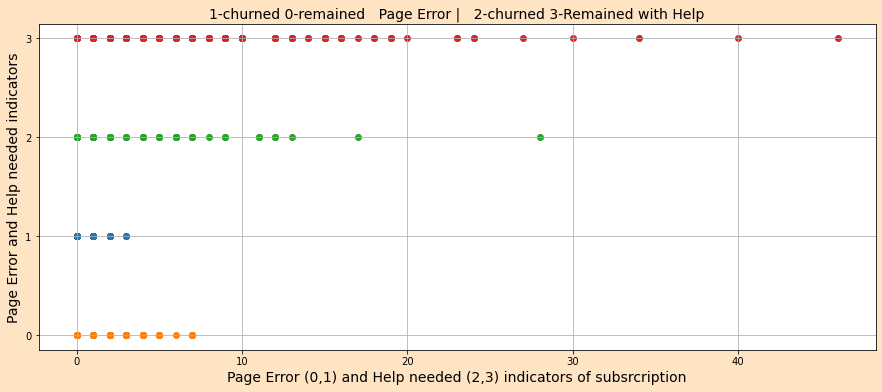

In [102]:
fig, ax = plt.subplots(figsize=(15, 6), edgecolor='b', facecolor='bisque')

plt.scatter(Page_error_help[Page_error_help["is_cancelled"] == 1]["total_page_error"],         
            Page_error_help[Page_error_help["is_cancelled"] == 1]["is_cancelled"])

plt.scatter(Page_error_help[Page_error_help["is_cancelled"] == 0]["total_page_error"], 
            Page_error_help[Page_error_help["is_cancelled"] == 0]["is_cancelled"])
#----------------------------------------------------------------------------------------------------
plt.scatter (Page_error_help[Page_error_help["also_cancelled"] == 2]["total_help_needed"], 
             Page_error_help[Page_error_help["also_cancelled"] == 2]["also_cancelled"])

plt.scatter(Page_error_help[Page_error_help["also_cancelled"] == 3]["total_help_needed"], 
            Page_error_help[Page_error_help["also_cancelled"] == 3]["also_cancelled"])
#-------------------------------------------------------------------------


plt.yticks((0, 1, 2, 3))
plt.title("1-churned 0-remained   Page Error |   2-churned 3-Remained with Help", fontsize=14)
plt.xlabel("Page Error (0,1) and Help needed (2,3) indicators of subsrcription", fontsize=14)
plt.ylabel("Page Error and Help needed indicators", fontsize=14)
plt.grid()

`View summary:` We can see there that the number of errors in pages and needed help were relatively lower and users seems not bothered by that. This could just be a coincidince because the sample size is smaller. Help page is keeping more users with the service than page-errors.

### 6. `Rolling Advertisement on unsubscribing`

In [103]:
# Find song time in correlation with cancellation
Roll_Advert_cancellation = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_cancelled,
           SUM(CASE WHEN page = 'Roll Advert' THEN 1 ELSE 0 END) AS total_roll_advert
    FROM df_local_view
    GROUP BY userId
""").toPandas()

In [104]:
Roll_Advert_cancellation.head(4)

,userId,is_cancelled,total_roll_advert
0,100010,0,52
1,200002,0,7
2,125,1,1
3,51,1,0


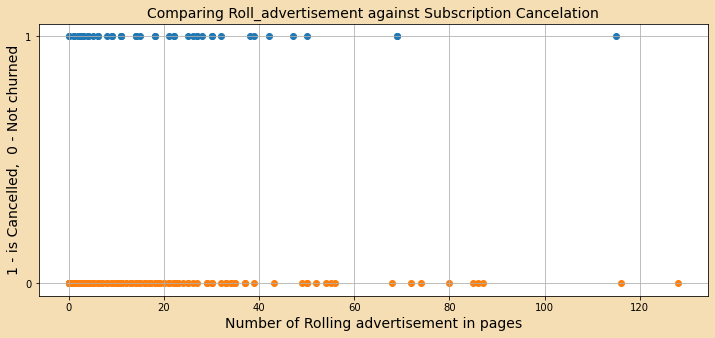

In [105]:
fig, ax = plt.subplots(figsize=(12, 5), edgecolor='b', facecolor='wheat')

plt.scatter(Roll_Advert_cancellation[Roll_Advert_cancellation["is_cancelled"] == 1]["total_roll_advert"], 
            Roll_Advert_cancellation[Roll_Advert_cancellation["is_cancelled"] == 1]["is_cancelled"])
#-------------------------------------------------------------------------
plt.scatter(Roll_Advert_cancellation[Roll_Advert_cancellation["is_cancelled"] == 0]["total_roll_advert"], 
            Roll_Advert_cancellation[Roll_Advert_cancellation["is_cancelled"] == 0]["is_cancelled"])


plt.yticks((0, 1))
plt.title("Comparing Roll_advertisement against Subscription Cancelation", fontsize=14)
plt.xlabel("Number of Rolling advertisement in pages", fontsize=14)
plt.ylabel("1 - is Cancelled,  0 - Not churned", fontsize=14)
plt.grid()

`Visuals: ` More `rolling advertisement` obviously have some effect on unsubscribing the streaming service. There is a parallel trend meaning more advertisment more churning.

### `Page scatterPlot Summary Findings: `

`A.` Most widely used pages are 'Home', 'ThumbsUp', 'AddtoPlaylist', 'LogOut', 'RollAdvert', 'AddFriends'.

`B.` It seems users who are adding more friends tends to remain with the service.

`C.` Adding more song to playlist keeps people with the service.

`D.` Rolling advertisement definitely has caused some users to churn out of the service.

`E.` ThumbsDown does not influence users decision to leave the service more.

`F.` Adding more `thumbsUp` keeping users with the service almost definitely.

`G.` Page error and help needed were not a big factor in unsubcribing the service.

## `Browser and Operating platform of the users:`

Browsers and operating platforms are not effecting in user's decision for churning the music service in a dominant way. This is just an overview of how these tools might influence potential customers behavior. 

In [106]:
def normalize_data(grouped_data):
    grouped_series = grouped_data.set_index(list(grouped_data.columns[:2]))
    temp = grouped_series.unstack('churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    return df
# source: 5 with reference...

`PLATFORM USAGE`

In [107]:
userAgent_count = spark.sql('''
                  SELECT userAgent, COUNT(DISTINCT userId) AS user_counts
                  FROM df_local_view
                  GROUP BY userAgent
                  ORDER BY user_counts DESC
''').toPandas()

In [108]:
df_cleaned.dropDuplicates(["userId"]).groupby(["userAgent","userId"]).count().sort('userId',ascending=False).limit(5).toPandas()

,userAgent,userId,count
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",99,1
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98,1
2,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",97,1
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",96,1
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95,1


In [109]:
#platform_dictionary = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
#          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
#          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [110]:
# convert user systems into four categories: Windows, Apple, Linux, other
df_cleaned_churned = df_cleaned_churned.withColumn('oper_platform',
                    when((col("userAgent").contains('compatible'))     | (col("userAgent").contains('Windows NT 5.1')) |\
                         (col("userAgent").contains('Windows NT 6.0')) | (col("userAgent").contains('Windows NT 6.1')) |\
                         (col("userAgent").contains('Windows NT 6.2')) | (col("userAgent").contains('Windows NT 6.3')), 'Windows')\
                                   
                        .when((col("userAgent").contains('Macintosh')) | (col("userAgent").contains('iPhone'))\
                                                                       | (col("userAgent").contains('iPad')), 'Apple')\
                        .when((col("userAgent").contains('X11')) | (col("userAgent").contains('Linx')), 'Linux')                                 
                        .otherwise('other'))
#df_cleaned_churned.limit(2).toPandas()

In [111]:
platform_data = df_cleaned_churned.select(['oper_platform', 'churn']).groupby(['oper_platform', 'churn']).\
                              count().sort('oper_platform').toPandas()
platform_data.head(3)

,oper_platform,churn,count
0,Apple,1,18365
1,Apple,0,106957
2,Linux,1,1762


`BROWSERS USAGE`

In [112]:
# convert user systems into four categories: Windows, Apple, Linux, other
df_cleaned_churned = df_cleaned_churned.withColumn('browsers',
                    when(col("userAgent").contains('Chrome'), 'Chrome')
                    .when((col("userAgent").contains('Firefox')), 'Firefox')
                    .when(col("userAgent").contains('Safari'), 'Safari')
                    .otherwise('IE'))

#df_cleaned_churned.limit(2).toPandas()

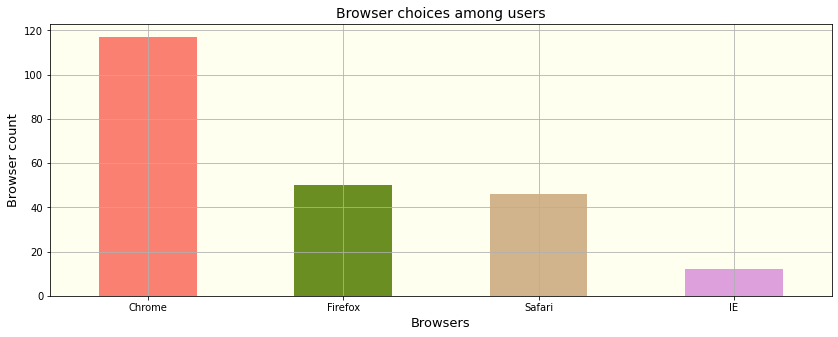

In [113]:
browser_selection = df_cleaned_churned.dropDuplicates(["userId"]).groupby(["userId","browsers"]).count().\
                                                                sort('userId',ascending=False).toPandas()
fig, ax = plt.subplots(figsize=(14,5))

ax = browser_selection.groupby('browsers')['count'].sum().sort_values(ascending=False).plot(kind='bar', color=(['salmon','olivedrab','tan','plum']))                                                                                                  
ax.set_facecolor('ivory')

ax.set_xlabel('Browsers', fontsize=13)
ax.set_ylabel('Browser count', fontsize=13)
ax.set_title("Browser choices among users", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.grid()

In [114]:
browsers_data = df_cleaned_churned.select(['browsers','churn']).groupby(['browsers', 'churn']).\
                            count().sort('browsers').toPandas()
browsers_data.head(3)

,browsers,churn,count
0,Chrome,1,20561
1,Chrome,0,125030
2,Firefox,1,14847


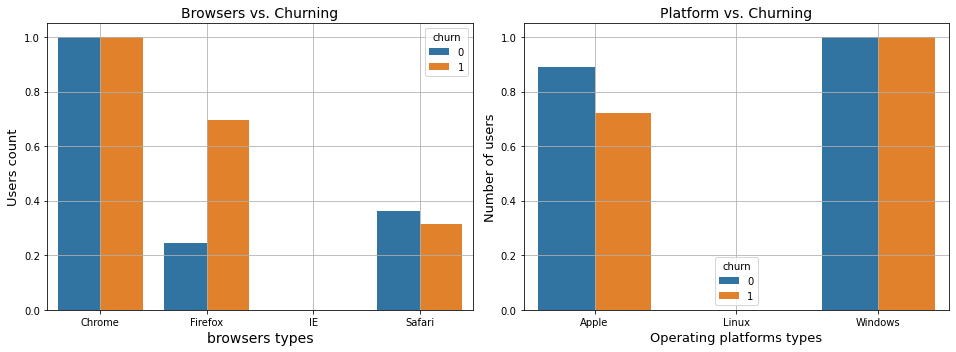

In [115]:
platform_data = normalize_data(platform_data)
browsers_data = normalize_data(browsers_data)

plt.figure(figsize=(20,5))
# --------Browsers--------------
plt.subplot(131)
sns.barplot( x="browsers", y="count", hue="churn", data=browsers_data);

plt.title("Browsers vs. Churning", fontsize=14)
plt.xlabel("browsers types", fontsize=14)
plt.ylabel("Users count", fontsize=13)
plt.grid()
ax.set_facecolor('ivory')

#--------Platform----------------------
plt.subplot(132)
sns.barplot(x='oper_platform', y='count', hue='churn', data=platform_data)

plt.title('Platform vs. Churning', fontsize=14)
plt.xlabel("Operating platforms types", fontsize=13)
plt.ylabel("Number of users", fontsize=13)
plt.grid()
ax.set_facecolor('ivory')

plt.tight_layout()

`Browser and Platform distribution: ` It is obvious that there are more `Chrome`, `Firefox` than `Safari` browsers. `Windows operating system` is more widely used than `Apple systems` thereby churning is correlated just by the market share nothing more.

`Scaled summary visual:` Typically 'Google' has a dominant market share in broswers market and it is obvious that more people have churned out from `Chrome based` devices than Apple-Safari or Firefox devices. There was no drastic relations of churning with one kind of broswers or the others. This visual offers a view where data is scaled.   

## `Churning effect on hourly, daily, monthly basis among users:`

In [116]:
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [117]:
df_cleaned_churned = df_cleaned_churned.withColumn("month", get_month(df_cleaned_churned.ts))
df_cleaned_churned = df_cleaned_churned.withColumn("day",   get_day(df_cleaned_churned.ts))
df_cleaned_churned = df_cleaned_churned.withColumn("hour",  get_hour(df_cleaned_churned.ts))

df_cleaned_churned = df_cleaned_churned.withColumn("weekday",  get_weekday(df_cleaned_churned.ts))

In [118]:
df_cleaned_churned.take(1)                     

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, oper_platform='Apple', browsers='Safari', month=10, day=8, hour=5, weekday='1')]

In [119]:
print("Statistical analysis of month column: ")
df_cleaned_churned.select("month").describe().show()

Statistical analysis of month column: 
+-------+------------------+
|summary|             month|
+-------+------------------+
|  count|            278154|
|   mean|10.472540391294032|
| stddev|0.5024405873732121|
|    min|                 9|
|    max|                12|
+-------+------------------+



Text(0.5, 1.0, 'Churing and remained users from October to December months')

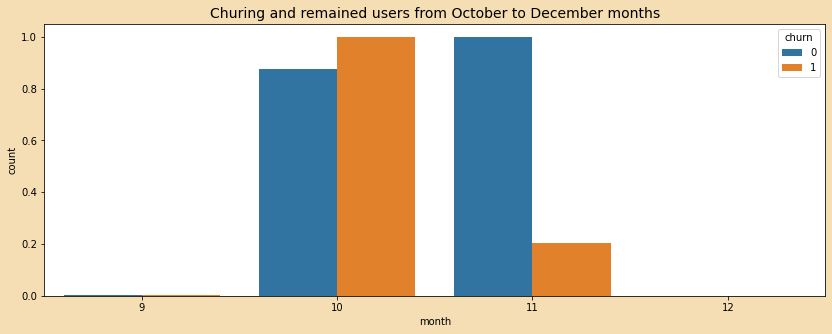

In [120]:
month_data = df_cleaned_churned.select(["churn", "month"]).groupby(["churn", "month"]).count().sort("month").toPandas()
month_data = normalize_data(month_data)

fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='wheat')

sns.barplot( x="month",y="count", hue="churn", data=month_data ) 
ax.set_title("Churing and remained users from October to December months", fontsize=14)

`Monthly churning: ` Monthly data available only for 3 months which is inadequate to decide a trend of churning behavior in rest of the years.

Text(0.5, 1.0, 'Churned and Remained users on Daily basis')

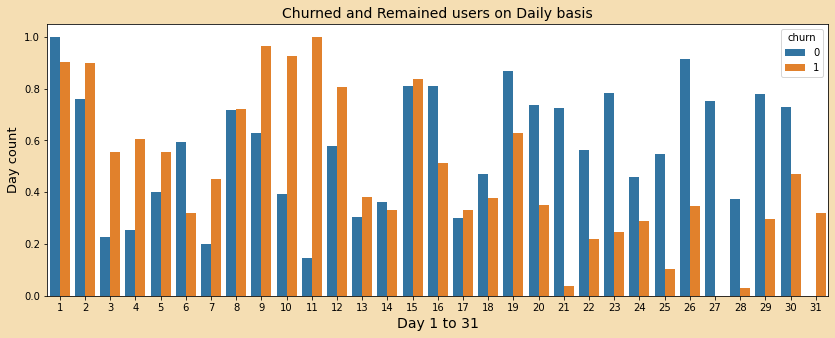

In [121]:
day_data = df_cleaned_churned.select(["churn", "day"]).groupby(["churn", "day"]).count().sort("day").toPandas()
day_data = normalize_data(day_data)

fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='wheat')

ax = sns.barplot( x="day",y="count", hue="churn", data=day_data ) 
ax.set_xlabel("Day 1 to 31", fontsize=14)
ax.set_ylabel("Day count", fontsize=13)
ax.set_title("Churned and Remained users on Daily basis", fontsize=14)

- An interesting observation is there are more churning is happening until the 15th of each month. From 16th on to the end of the month churning reduce down to half of retained/stayed customers.

Text(0.5, 1.0, 'Churned and Remained users on Hourly basis')

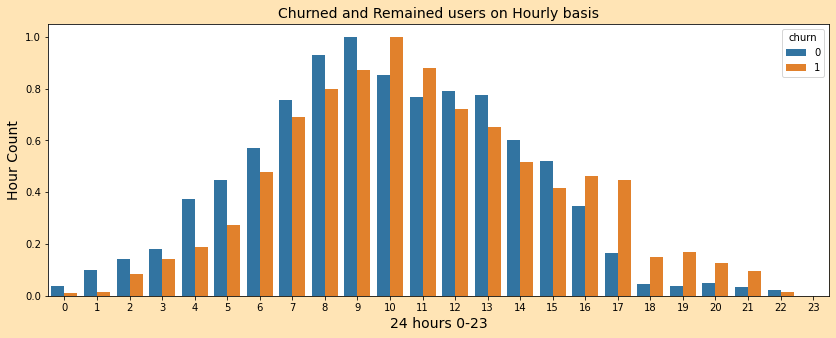

In [122]:
hour_data = df_cleaned_churned.select(["churn", "hour"]).groupby(["churn", "hour"]).count().sort("hour").toPandas()
hour_data = normalize_data(hour_data)

fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='moccasin')
ax = sns.barplot( x="hour",y="count", hue="churn", data=hour_data);
ax.set_xlabel("24 hours 0-23", fontsize=14)
ax.set_ylabel("Hour Count", fontsize=14)
ax.set_title("Churned and Remained users on Hourly basis", fontsize=14)

- Most number of churning happen at the 10 am 11 am morning time then slowly it goes down and again 16th and 17th hour goes up again.

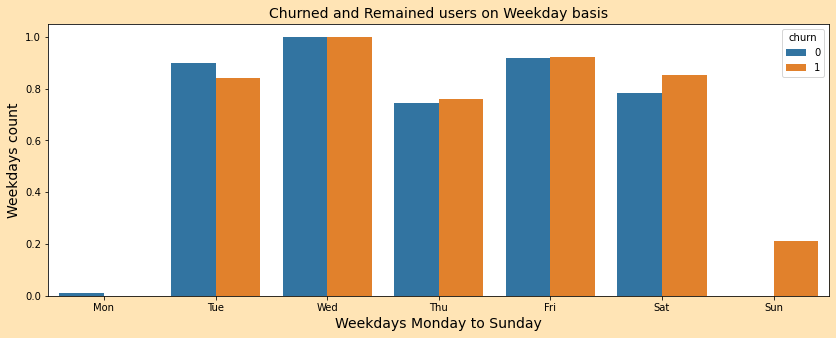

In [123]:
weekday_data = df_cleaned_churned.select(["churn", "weekday"]).groupby(["churn", "weekday"]).count().sort("weekday").toPandas()
weekday_data = normalize_data(weekday_data)

fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='moccasin')
ax = sns.barplot( x="weekday",y="count", hue="churn", data=weekday_data);
ax.set_xlabel("Weekdays Monday to Sunday", fontsize=14)
ax.set_ylabel("Weekdays count", fontsize=14)
ax.set_title("Churned and Remained users on Weekday basis", fontsize=14)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0);

`Day wise churning: ` It seems Monday have least or no chuning next is Sunday. The rest of the weekdays stays almost the same rate of churning transition sequence.

In [124]:
from pyspark.sql.functions import split
df_cleaned_churned = df_cleaned_churned.withColumn("city", split(col("location"), ",").getItem(0)).\
                         withColumn("state", split(col("location"), ",").getItem(1))

In [125]:
# source: https://www.datasciencemadesimple.com/string-split-of-the-columns-in-pyspark/

In [126]:
city_data = df_cleaned_churned.dropDuplicates(["userId"]).groupby(["city","churn"]).count().\
                                                     sort("city",ascending=True).toPandas()
#city_data = normalize_data(city_data)

In [127]:
state_data = df_cleaned_churned.dropDuplicates(["userId"]).groupby(["state","churn"]).count().\
                                                     sort("state",ascending=True).toPandas()
#state_data = normalize_data(state_data)

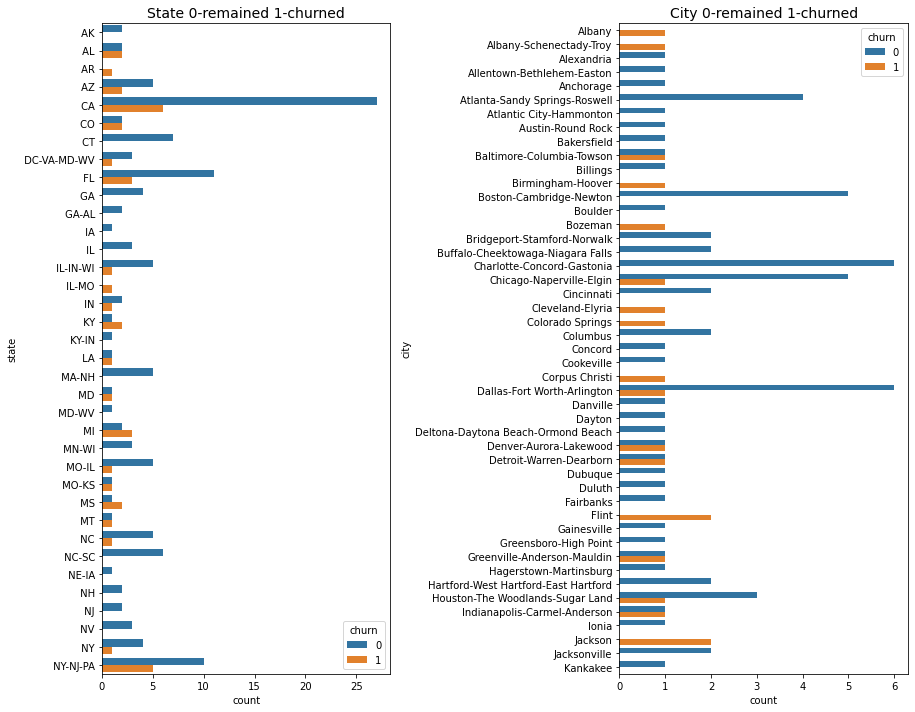

In [128]:
plt.figure(figsize=(20,10))

# State wise churning
plt.subplot(131)
plt.title('State 0-remained 1-churned', fontsize=14)
sns.barplot( x="count",y="state", hue="churn", data=state_data[:55]);

# city wise churning
plt.subplot(132)
plt.title('City 0-remained 1-churned', fontsize=14)
sns.barplot( x="count",y="city", hue="churn", data=city_data[:55]);

plt.tight_layout()
plt.show()

`Location and churning: ` This is very a clean visualization of users' churning trend based on city and state.

# `Feature Engineering processes:`

Now that we have a better grasp of the data that we're given, lets start thinking about feature engineering and manipulation. We know feature engineering involves the application of business knowledge, statistics to transform data into a format that can be directly used by machine learning models. Irrespective of the algorithm used, feature engineering drives model performances to generate meaningful insights, and ultimately critical solve business problems. Primary objectives are..

- Manipulating existing features with analytical relevancy to other features.
- Redesigning new and complex but needed feature relationship.
- Finding complex inter-relational important values among existing features.

We will do these options by aggregating features and joining multiple tables into a single dataframe while using statistical transformations with relevant relational operations. On these progression we will convert all object columns into numerical ones.

> The ultimate leverage of feature manipulation is to predict customers who will likely churn out of the service with the highest probability. If we can correctly identify those customers, we might be able to retain them as a cotinued customer with new promotions.

In [271]:
df_cleaned_churned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- oper_platform: string (nullable = false)
 |-- browsers: string (nullable = false)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- city: string (nullable = true

**`Quick summary of feature transformations:`**

- In the first function we renamed existing column and added 4 new columns
- In the second function we renamed and recreated 7 new colmns
- Aggregating features as relevant and joining those two functions
- Renaming mulitple of the sub-selected columns
- Then we applied log-transformation on large numeric datatypes
- At this point the dataset is ready for Vectorization and Scaling processes

`Note:` Computation time with `PySpark` was a factor for not trying more new feature engineering aspects.

### `Total number of columns we'd be working with`

In [140]:
features_chosen = df_cleaned_churned.select(['userId','auth','gender','level','page','ts','registration','length','hour','day'])
features_chosen.show(2)

+------+---------+------+-----+--------+-------------+-------------+---------+----+---+
|userId|     auth|gender|level|    page|           ts| registration|   length|hour|day|
+------+---------+------+-----+--------+-------------+-------------+---------+----+---+
|    30|Logged In|     M| paid|NextSong|1538352117000|1538173362000|277.89016|  17| 30|
|     9|Logged In|     M| free|NextSong|1538352180000|1538331630000|236.09424|  17| 30|
+------+---------+------+-----+--------+-------------+-------------+---------+----+---+
only showing top 2 rows



In [141]:
def get_basic_features():
    '''
    INPUT:
    There will be no input
    We will be sub-selecting 7 relevent columns 
    We will be renaming and recreating new columns....
    
    OUTPUT:
    Final output will contain 'userId' in correlation with newly formatted columns 
    '''
    basic_features = df_cleaned_churned.select(['userId','auth','gender','level','ts','registration','length','hour','day'])
    #--------------------------------------------------------------
    male_gender = udf(lambda x: 1 if x=='M' else 0, IntegerType())
    
    # add downgrade variable
    basic_features = basic_features.withColumn("Male_Female", male_gender("gender"))
    
    #---------------------------------------------------------------
    auth_selection = udf(lambda x: 1 if x=='Logged In' else 0, IntegerType())
    basic_features = basic_features.withColumn("LogIn_Cancelled", auth_selection("auth"))
        
    #------------------------------------------------------
    # define function
    level_event = udf(lambda x: 1 if x == "paid" else 0, IntegerType())

    # add gender variable
    basic_features = basic_features.withColumn("paid_free", level_event("level"))
    
    #------------------------
    calculate_time = udf(lambda x,y: x-y if x>=y else 0, LongType())

    # add gender variable
    result = basic_features.withColumn("timeSinceRegistration", calculate_time("ts", "registration"))   
    
    return result

In [142]:
main_features_only = get_basic_features()
#basic_features_only.limit(3).toPandas()

In [143]:
main_features_only.dtypes

[('userId', 'string'),
 ('auth', 'string'),
 ('gender', 'string'),
 ('level', 'string'),
 ('ts', 'bigint'),
 ('registration', 'bigint'),
 ('length', 'double'),
 ('hour', 'int'),
 ('day', 'int'),
 ('Male_Female', 'int'),
 ('LogIn_Cancelled', 'int'),
 ('paid_free', 'int'),
 ('timeSinceRegistration', 'bigint')]

In [144]:
# deleting 'string' features to keep only numerical value features
columns = ['auth','gender','level']
main_features_only = main_features_only.drop(*columns)
main_features_only.show(3)

+------+-------------+-------------+---------+----+---+-----------+---------------+---------+---------------------+
|userId|           ts| registration|   length|hour|day|Male_Female|LogIn_Cancelled|paid_free|timeSinceRegistration|
+------+-------------+-------------+---------+----+---+-----------+---------------+---------+---------------------+
|    30|1538352117000|1538173362000|277.89016|  17| 30|          1|              1|        1|            178755000|
|     9|1538352180000|1538331630000|236.09424|  17| 30|          1|              1|        0|             20550000|
|    30|1538352394000|1538173362000| 282.8273|  17| 30|          1|              1|        1|            179032000|
+------+-------------+-------------+---------+----+---+-----------+---------------+---------+---------------------+
only showing top 3 rows



### `Page features reengineering`

In [145]:
df_cleaned_churned.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [146]:
def get_page_features():
    '''
    INPUT:
    Sub-selecting 3 relevent features 
    We will be manipulating page columns into multiple sub category columns
    to make sure all new columns are in number type dataset
    
    OUTPUT:
    Final output will contain 'userId' and newly formatted feature columns    
    '''
    page_features = df_cleaned_churned.select(['userId','page','sessionId', 'artist'])
    
    # add downgrade variable
    downgraded_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

    page_features = page_features.withColumn("downgraded", downgraded_event("page"))

    #-----Roll Advert---------------------------------------------------------------
    roll_advert_event = udf(lambda x:1 if x == "Roll Advert" else 0, IntegerType())
    
    page_features = page_features.withColumn("rolling_Ad", roll_advert_event("page"))
        
    # # define PLaylist-------------------------------------------------------------
    playlist_event = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

    # add playlist variable
    page_features = page_features.withColumn("playlistSongs", playlist_event("page"))
    
    #------------Add friends-----------------------------------------------------
    Add_Friend_event = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
    page_features = page_features.withColumn('addedFreind', Add_Friend_event('page'))
    
    # add thumbs-up variable--------------------------------------------------
    thumbs_up_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
    page_features = page_features.withColumn('thumbsUp', thumbs_up_event('page'))

    # define function------------------------------------------------------------
    thumbs_down_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
    page_features = page_features.withColumn('thumbsDown', thumbs_down_event('page'))
    
    #==================================================================================
    # define function---------------------------------------------------
    song_event = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
    
    # add songs variable
    page_features = page_features.withColumn("songChoice", song_event("page"))
    
    
    ###------------PAGE --Interrelated sessions-----------------------------------------------------------##
    num_total_song = page_features.filter(page_features.page=='NextSong').select(["userId","songChoice"]).\
                                             dropDuplicates(["userId"]).groupby(["userId"]).count()
    
    num_total_song = num_total_song.selectExpr("userId as userId","count as num_total_song")
    
    #-------------------------------------------------------------------------------------------------- 
    # Number of session by each users
    num_sessions = page_features.filter(page_features.page == 'NextSong').select(['userId','sessionId']).\
                                                   dropDuplicates(["userId","sessionId"]).groupby(["userId"]).count()
    
    num_sessions = num_sessions.selectExpr("userId as userId", "count as user_sessions")    
    #----------------------------------------------------------------------------------
    #unique artists artist
    num_artist = page_features.filter(page_features.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    
    num_artist = num_artist.selectExpr("userId as userId","count as num_artist")
    
    #------------------------------------------------------------------------------------------------------------------
    combined_features =  page_features.join(num_total_song, on='userId').\
                                          join(num_sessions, on='userId').join(num_artist, on='userId')  
    # return a combined all modified columns
    return combined_features

In [147]:
page_features_subset = get_page_features()
columns = ['page', 'artist']
page_features_subset = page_features_subset.drop(*columns)
page_features_subset.show(3)

+------+---------+----------+----------+-------------+-----------+--------+----------+----------+--------------+-------------+----------+
|userId|sessionId|downgraded|rolling_Ad|playlistSongs|addedFreind|thumbsUp|thumbsDown|songChoice|num_total_song|user_sessions|num_artist|
+------+---------+----------+----------+-------------+-----------+--------+----------+----------+--------------+-------------+----------+
|100010|       31|         0|         0|            0|          0|       0|         0|         1|             1|            7|       252|
|100010|       31|         0|         0|            0|          0|       0|         0|         1|             1|            7|       252|
|100010|       31|         0|         0|            0|          0|       0|         0|         1|             1|            7|       252|
+------+---------+----------+----------+-------------+-----------+--------+----------+----------+--------------+-------------+----------+
only showing top 3 rows



In [148]:
page_features_subset.dtypes

[('userId', 'string'),
 ('sessionId', 'bigint'),
 ('downgraded', 'int'),
 ('rolling_Ad', 'int'),
 ('playlistSongs', 'int'),
 ('addedFreind', 'int'),
 ('thumbsUp', 'int'),
 ('thumbsDown', 'int'),
 ('songChoice', 'int'),
 ('num_total_song', 'bigint'),
 ('user_sessions', 'bigint'),
 ('num_artist', 'bigint')]

In [149]:
page_features_subset.limit(3).toPandas()

,userId,sessionId,downgraded,rolling_Ad,playlistSongs,addedFreind,thumbsUp,thumbsDown,songChoice,num_total_song,user_sessions,num_artist
0,100010,31,0,0,0,0,0,0,1,1,7,252
1,100010,31,0,0,0,0,0,0,1,1,7,252
2,100010,31,0,0,0,0,0,0,1,1,7,252


### `Combining all the data subsets`

In [150]:
userId_churn = df_cleaned_churned.select(['userId','churn']).dropDuplicates()
main_page_combined = main_features_only.join(page_features_subset, on='userId',how='inner').\
                                                join(userId_churn, on='userId', how='inner')

In [151]:
main_page_combined.show(3)

+------+-------------+-------------+---------+----+---+-----------+---------------+---------+---------------------+---------+----------+----------+-------------+-----------+--------+----------+----------+--------------+-------------+----------+-----+
|userId|           ts| registration|   length|hour|day|Male_Female|LogIn_Cancelled|paid_free|timeSinceRegistration|sessionId|downgraded|rolling_Ad|playlistSongs|addedFreind|thumbsUp|thumbsDown|songChoice|num_total_song|user_sessions|num_artist|churn|
+------+-------------+-------------+---------+----+---+-----------+---------------+---------+---------------------+---------+----------+----------+-------------+-----------+--------+----------+----------+--------------+-------------+----------+-----+
|100010|1539003534000|1538016340000|202.97098|   5|  8|          0|              1|        0|            987194000|       31|         0|         0|            0|          0|       0|         0|         1|             1|            7|       252|   

In [152]:
main_page_combined.dtypes

[('userId', 'string'),
 ('ts', 'bigint'),
 ('registration', 'bigint'),
 ('length', 'double'),
 ('hour', 'int'),
 ('day', 'int'),
 ('Male_Female', 'int'),
 ('LogIn_Cancelled', 'int'),
 ('paid_free', 'int'),
 ('timeSinceRegistration', 'bigint'),
 ('sessionId', 'bigint'),
 ('downgraded', 'int'),
 ('rolling_Ad', 'int'),
 ('playlistSongs', 'int'),
 ('addedFreind', 'int'),
 ('thumbsUp', 'int'),
 ('thumbsDown', 'int'),
 ('songChoice', 'int'),
 ('num_total_song', 'bigint'),
 ('user_sessions', 'bigint'),
 ('num_artist', 'bigint'),
 ('churn', 'bigint')]

### `Temporal aggregation and renaming features variables for feature minimization`

In [153]:
# Feature aggregation columns by userId
all_features_combined = main_page_combined.groupby(main_page_combined.userId).\
                        agg({"downgraded": "max", 
                                "Male_Female": "max",
                                    "paid_free": "max",
                                        "hour": "sum",
                                            "day": "sum",
                                                
                                "timeSinceRegistration": "max",
                                    "rolling_Ad": "sum",
                                        "playlistSongs": "sum",
                                          "thumbsUp": "sum",
                                             "thumbsDown": "sum",
                                               "length":"avg",
                             
                                    "songChoice":"sum", 
                                      "num_total_song": "sum",
                                         "num_artist": "sum",
                                            "user_sessions": "sum",
                                               "churn": "max"}) 

`RENAMING AGGREGATED FEATURES`

In [154]:
# Source: https://amiradata.com/pyspark-rename-column-on-pyspark-dataframe/
# renaming aggregated feture columns
users_features_inclusive = all_features_combined.select(col("userId"),
                    col("max(downgraded)").alias("downgraded"),
                        col("max(Male_Female)").alias("Male_Female"),
                            col("max(paid_free)").alias("paid_free"),
                                col("sum(hour)").alias("total_hour"),
                                    col("sum(day)").alias("num_days"),
                   
                        col("max(timeSinceRegistration)").alias("timeSinceRegistration"),
                            col("sum(rolling_Ad)").alias("rolling_Ad"),
                                col("sum(playlistSongs)").alias("playlistSongs"),
                                    col("sum(thumbsUp)").alias("thumbsUp"),
                                                        
                    col("sum(thumbsDown)").alias("thumbsDown"),
                        col("avg(length)").alias("length"),
                            col("sum(songChoice)").alias("songChoice"),
                                col("sum(num_total_song)").alias("num_total_song"),  
                                    col("sum(num_artist)").alias("num_artist"),
                                       col("sum(user_sessions)").alias("user_sessions"), 
                                         col("max(churn)").alias("churn"))
                                       

# present result
users_features_inclusive.show(3)

+------+----------+-----------+---------+----------+--------+---------------------+----------+-------------+--------+----------+------------------+----------+--------------+----------+-------------+-----+
|userId|downgraded|Male_Female|paid_free|total_hour|num_days|timeSinceRegistration|rolling_Ad|playlistSongs|thumbsUp|thumbsDown|            length|songChoice|num_total_song|num_artist|user_sessions|churn|
+------+----------+-----------+---------+----------+--------+---------------------+----------+-------------+--------+----------+------------------+----------+--------------+----------+-------------+-----+
|100010|         0|          0|        0|   1497711| 1711071|           4807612000|     19812|         2667|    6477|      1905|243.42144490910485|    104775|        145161|  36580572|      1016127|    0|
|200002|         0|          1|        1|   2120676| 3716634|           6054448000|      3318|         3792|    9954|      2844|242.91699209303025|    183438|        224676|  76165

In [155]:
users_features_inclusive.dtypes

[('userId', 'string'),
 ('downgraded', 'int'),
 ('Male_Female', 'int'),
 ('paid_free', 'int'),
 ('total_hour', 'bigint'),
 ('num_days', 'bigint'),
 ('timeSinceRegistration', 'bigint'),
 ('rolling_Ad', 'bigint'),
 ('playlistSongs', 'bigint'),
 ('thumbsUp', 'bigint'),
 ('thumbsDown', 'bigint'),
 ('length', 'double'),
 ('songChoice', 'bigint'),
 ('num_total_song', 'bigint'),
 ('num_artist', 'bigint'),
 ('user_sessions', 'bigint'),
 ('churn', 'bigint')]

In [156]:
#users_features_inclusive.limit(5).toPandas()

In [157]:
features_in_pandas = users_features_inclusive.toPandas()
features_in_pandas.groupby('churn').mean()

,downgraded,Male_Female,paid_free,total_hour,num_days,timeSinceRegistration,rolling_Ad,playlistSongs,thumbsUp,thumbsDown,length,songChoice,num_total_song,num_artist,user_sessions
churn,,,,,,,,,,,,,,,
0,0.231214,0.514451,0.745665,4.323380e+07,6.174784e+07,7.484022e+09,36143.358382,91853.242775,177210.780347,33293.075145,249.141254,3.170549e+06,3.838546e+06,7.721456e+09,1.827633e+08
1,0.173077,0.615385,0.692308,1.679000e+07,1.910449e+07,4.951238e+09,20262.923077,34437.269231,62874.634615,14020.269231,248.307865,1.200802e+06,1.456754e+06,1.815173e+09,3.069667e+07


### `Applying log transformation on large-value columns`

In [158]:
# Check average feature value for each target value
features_in_pandas = users_features_inclusive.toPandas()
features_in_pandas.groupby('churn').mean()

,downgraded,Male_Female,paid_free,total_hour,num_days,timeSinceRegistration,rolling_Ad,playlistSongs,thumbsUp,thumbsDown,length,songChoice,num_total_song,num_artist,user_sessions
churn,,,,,,,,,,,,,,,
0,0.231214,0.514451,0.745665,4.323380e+07,6.174784e+07,7.484022e+09,36143.358382,91853.242775,177210.780347,33293.075145,249.141254,3.170549e+06,3.838546e+06,7.721456e+09,1.827633e+08
1,0.173077,0.615385,0.692308,1.679000e+07,1.910449e+07,4.951238e+09,20262.923077,34437.269231,62874.634615,14020.269231,248.307865,1.200802e+06,1.456754e+06,1.815173e+09,3.069667e+07


In [159]:
# apply log to all continuous features
features_streamlined = users_features_inclusive.select(col("Male_Female"),
                                        col("downgraded"), col("paid_free"),
                    F.log(col("timeSinceRegistration") + 1).alias("timeSinceRegistration"),
                        F.log(col("playlistSongs") + 1).alias("playlistSongs"),
                          F.log(col("rolling_Ad") + 1).alias("rolling_Add"),                            
                            F.log(col("thumbsUp") + 1).alias("thumbsUp"),
                                F.log(col("thumbsDown") + 1).alias("thumbsDown"),
                                   F.log(col("length") + 1).alias("length"),
                                     F.log(col("songChoice") + 1).alias("songChoice"),
                                        F.log(col("num_total_song") + 1).alias("num_total_song"),
                                          F.log(col("num_artist") + 1).alias("num_artist"),
                                            F.log(col("user_sessions") + 1).alias("user_sessions"),
                                             F.log(col("num_days") + 1).alias("num_days"),
                                                F.log(col("total_hour") + 1).alias("total_hour"),
                                                       col("churn"))

In [160]:
features_streamlined.dtypes

[('Male_Female', 'int'),
 ('downgraded', 'int'),
 ('paid_free', 'int'),
 ('timeSinceRegistration', 'double'),
 ('playlistSongs', 'double'),
 ('rolling_Add', 'double'),
 ('thumbsUp', 'double'),
 ('thumbsDown', 'double'),
 ('length', 'double'),
 ('songChoice', 'double'),
 ('num_total_song', 'double'),
 ('num_artist', 'double'),
 ('user_sessions', 'double'),
 ('num_days', 'double'),
 ('total_hour', 'double'),
 ('churn', 'bigint')]

In [161]:
# to view how newly created features affect on churning..
features_streamlined.toPandas().groupby('churn').mean().head(3)  

,Male_Female,downgraded,paid_free,timeSinceRegistration,playlistSongs,rolling_Add,thumbsUp,thumbsDown,length,songChoice,num_total_song,num_artist,user_sessions,num_days,total_hour
churn,,,,,,,,,,,,,,,
0,0.514451,0.231214,0.745665,22.632942,9.221374,8.168837,10.007560,7.999916,5.521801,12.966921,13.187744,19.321687,15.461751,15.929829,15.583733
1,0.615385,0.173077,0.692308,22.103498,8.369453,8.093355,8.941163,7.557110,5.518217,11.995807,12.263976,17.950117,14.191401,14.636405,14.675564


In [162]:
# display size after all feature transformation
print('We got ', users_features_inclusive.count(),'rows and ', len(users_features_inclusive.columns), 'columns')

We got  225 rows and  17 columns


In [163]:
# separating the columns
final_dataSet_columns = features_streamlined.columns
print("Before removing  target columns: ['churn'] ")
final_dataSet_columns

Before removing  target columns: ['churn'] 


['Male_Female',
 'downgraded',
 'paid_free',
 'timeSinceRegistration',
 'playlistSongs',
 'rolling_Add',
 'thumbsUp',
 'thumbsDown',
 'length',
 'songChoice',
 'num_total_song',
 'num_artist',
 'user_sessions',
 'num_days',
 'total_hour',
 'churn']

In [164]:
# create pandas version of dataset after log-transformation
#features_streamlined_pandas = features_streamlined.toPandas()
#features_streamlined_pandas.groupby('churn').mean()

### `Applying 'Vectorization + Scaling' on the final dataset`

`Note:`  Some algorithms like Logistics Regression and SVC peforms poorly if the dataset is not scaled. So we will do scaling of the vectorized dataset to be in safer side.

In [169]:
# removing the target columns
final_dataSet_columns.remove('churn')
print("After removing  target columns:['churn']")
final_dataSet_columns

After removing  target columns:['churn']


['Male_Female',
 'downgraded',
 'paid_free',
 'timeSinceRegistration',
 'playlistSongs',
 'rolling_Add',
 'thumbsUp',
 'thumbsDown',
 'length',
 'songChoice',
 'num_total_song',
 'num_artist',
 'user_sessions',
 'num_days',
 'total_hour']

In [170]:
# Applying vectorization on the redefined dataset
assembler = VectorAssembler(inputCols = final_dataSet_columns, outputCol="Num_Features")
data = assembler.setHandleInvalid('skip').transform(features_streamlined)

In [171]:
# Scaling to mean 0 and unit std dev
scaler = StandardScaler(inputCol='Num_Features', outputCol='features_scaled', withMean=True, withStd=True)
ScaledDataSet = scaler.fit(data)
data = ScaledDataSet.transform(data)

In [172]:
data.limit(3).toPandas()

,Male_Female,downgraded,paid_free,timeSinceRegistration,playlistSongs,rolling_Add,thumbsUp,thumbsDown,length,songChoice,num_total_song,num_artist,user_sessions,num_days,total_hour,churn,Num_Features,features_scaled
0,0,0,0,22.293466,7.889084,9.894094,8.776167,7.552762,5.498894,11.559580,11.885606,17.415028,13.831510,14.352631,14.219449,0,"[0.0, 0.0, 0.0, 22.293466332295722, 7.88908440...","[-1.0762390990345028, -0.5264710031632485, -1...."
1,1,0,1,22.524059,8.240913,8.107419,9.205830,7.953318,5.496828,12.119637,12.322419,18.148415,14.114175,15.128329,14.567246,0,"[1.0, 0.0, 1.0, 22.524059045633912, 8.24091254...","[0.9250319528891594, -0.5264710031632485, 0.60..."
2,1,0,0,22.541631,0.000000,2.484907,0.000000,0.000000,5.568875,4.488636,4.804021,6.876265,4.804021,7.194437,7.840706,1,"[1.0, 0.0, 0.0, 22.54163137166111, 0.0, 2.4849...","[0.9250319528891594, -0.5264710031632485, -1.6..."


In [173]:
# renaming target and features-columns
final_dataSet = data.select(data.churn.alias("label"), data.features_scaled.alias("features"))
final_dataSet.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-1.0762390990345...|
|    0|[0.92503195288915...|
|    1|[0.92503195288915...|
+-----+--------------------+
only showing top 3 rows



In [174]:
# displaying label count
final_dataSet.groupby(final_dataSet.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



### `Balancing minority (churning) class`

- Since we have a highly imbalanced target value churned `52` which is around `1/3` of the non-churned `173`, we will apply undersampling in pursuasion of creating a balanced dataset.

In [175]:
def undersample(df, minority, majority): 
    '''
    Implement undersample on dataset, return a balanced dataset.
    '''    
    # size of minority class(0)
    minoritySize = df.where(df.label == minority).count()
    
    # two classes with the same size
    df_minority = df.where(df.label == minority)
    df_majority = df.where(df.label == majority).sample(1.0, seed=7).limit(minoritySize)
    
    # concatenate them together
    result = df_minority.union(df_majority)
    
    #shuffle data
    result = result.orderBy(rand())
    return result

In [176]:
# applying balancing function
balanced_dataSet = undersample(final_dataSet, 1, 0)

# finding the lable count
balanced_dataSet.groupby(balanced_dataSet.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   52|
|    1|   52|
+-----+-----+



In [177]:
balanced_dataSet.toPandas().head(4)

,label,features
0,0,"[0.9250319528891594, -0.5264710031632485, -1.6..."
1,0,"[-1.0762390990345028, -0.5264710031632485, -1...."
2,0,"[0.9250319528891594, -0.5264710031632485, 0.60..."
3,0,"[0.9250319528891594, -0.5264710031632485, -1.6..."


## `ML modeling with DataSet splitting:`

In [189]:
df_train, df_test = balanced_dataSet.randomSplit([0.8, 0.2], seed=15)

In [190]:
print("Now the shape of df_train dataset: ",(df_train.count(), len(df_train.columns)))

Now the shape of df_train dataset:  (87, 2)


In [191]:
print("Now the shape of df_test dataset: ",(df_test.count(), len(df_test.columns)))

Now the shape of df_test dataset:  (17, 2)


Since our target variable is a binary classification choice, I've decided to use accuracy and f-1 score. Considering we have a balanced dataset makes accuracy is the prime metric to observe also they're easy to interpret. 

- Accuracy describes how often our model is correct regardless of the type of errors it makes.
- F-1 score balances the tradeoff between precision and recall. 
- precision (how often is the model correct over every "positive" prediction) and 
- recall (how many of the total "positive" instances were identified correctly).
- Confusion Matrix to visualize the performance of an algorithm.

In [192]:
import time
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")

In [193]:
# securing metrics to choose
accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [194]:
# Initialize five models
clf_LR = LogisticRegression(maxIter=40)
clf_SVC = LinearSVC()
clf_RF = RandomForestClassifier(numTrees = 10, seed=35)
clf_DT = DecisionTreeClassifier(seed=30)

In [195]:
def model_evalutaion_processes(model, train, test):
    '''
    Inputs:
          model: selecting specific model
          train: df_train dataset(train_split)
          test: df_test dataset(test_split)
    Output:
          accuracy: train/test data set accuracy
          f1-score: train/test dataset f1-score
    '''
    #---------------TRAIN SET-------------------
    start = time.time()
    # fitting trining dataset with the algorithm
    fitted_model = model.fit(train)
    end = time.time()
    print(f'Train_df fitting time: {end-start} seconds.')    
    #---------------- prediction on test set --------------------------
    start = time.time()
    pred_train = fitted_model.transform(train)
    end = time.time()
    print(f'Train_df prediction time: {end-start} seconds')
    
    train_accuracy = accuracy_evaluator.evaluate(pred_train)
    train_f1_score = f1_evaluator.evaluate(pred_train) 
    print("Train_df accuracy rate: ", (train_accuracy))
    print("Train_df f1_score:", (train_f1_score))
    #------------------------TEST DATASET -----------------------
    start = time.time()
    pred_test = fitted_model.transform(test)
    end = time.time()
    print("\n")
    print(f'Test_df prediction time: {end-start} seconds')
    # calculating accuracy and f1-score
    test_accuracy = accuracy_evaluator.evaluate(pred_test) 
    test_f1_score = f1_evaluator.evaluate(pred_test)
    print("Test_df accuracy rate: ", (test_accuracy))
    print("Test_df f1_score:", (test_f1_score))

### `1.` `LOGISTIC REGRESSION CLASSIFIER`       `NON-PARAMETRIC`

In [196]:
print('LogisticRegression "Train/Test" fitting and predicting performance: \n')
model_evalutaion_processes(clf_LR, df_train, df_test)

LogisticRegression Train/Test fitting and predicting performance: 

Train_df fitting time: 333.7577645778656 seconds.
Train_df prediction time: 0.04687356948852539 seconds
Train_df accuracy rate:  0.8160919540229885
Train_df f1_score: 0.816237912789637


Test_df prediction time: 0.04390406608581543 seconds
Test_df accuracy rate:  0.7058823529411765
Test_df f1_score: 0.7101917690152983


### `2.` `LINEAR SUPPORT VECTOR CLASSIFIER MODEL:`

In [197]:
print('Linear Support Vector Classifier "Train/Test" fitting and predicting performance: \n')
model_evalutaion_processes(clf_SVC, df_train, df_test)

Linear Support Vector Classifier "Train/Test" fitting and predicting performance: 

Train_df fitting time: 785.255295753479 seconds.
Train_df prediction time: 0.03291153907775879 seconds
Train_df accuracy rate:  0.5172413793103449
Train_df f1_score: 0.5163426265590609


Test_df prediction time: 0.03137516975402832 seconds
Test_df accuracy rate:  0.5294117647058824
Test_df f1_score: 0.5359477124183007


### `3.` `RANDOM FOREST CLASSIFIER:`

In [198]:
print('Random Forest "Train/Test" fitting and predicting performance: \n')
model_evalutaion_processes(clf_RF, df_train, df_test)

Random Forest "Train/Test" fitting and predicting performance: 

Train_df fitting time: 847.7167658805847 seconds.
Train_df prediction time: 0.06088614463806152 seconds
Train_df accuracy rate:  0.9310344827586207
Train_df f1_score: 0.9310892172961138


Test_df prediction time: 0.047380685806274414 seconds
Test_df accuracy rate:  0.5294117647058824
Test_df f1_score: 0.5359477124183007


### `4.` `DECISION TREE CLASSIFIER:`

In [199]:
print('Decision Tree "Train/Test" fitting and predicting performance: \n')
model_evalutaion_processes(clf_DT, df_train, df_test)

Decision Tree "Train/Test" fitting and predicting performance: 

Train_df fitting time: 793.8072504997253 seconds.
Train_df prediction time: 0.04188823699951172 seconds
Train_df accuracy rate:  0.9310344827586207
Train_df f1_score: 0.9309798060800467


Test_df prediction time: 0.0578458309173584 seconds
Test_df accuracy rate:  0.5882352941176471
Test_df f1_score: 0.5969040247678018


**`PARAMETRIC CLASSIFICATION EVALUATION FUNCTION`**

In [201]:
def model_classification_scores(inputResult):
    """
    Prints classification scores given tp, tn, fp and fn.
    
    :Inputs:
        :tp: True positives
        :tn: True Negatives
        :fp: False Positives
        :fn: False Negatives
        
    :Print outputs:
        :accuracy: Number of correct classifications 
        :precision: Number of true positives out of positive classifications
        :recall: Number of true positives out of those that should have been true positives
        :f1: Harmonic mean of precision and recall, good overall stat
    """
    tp = inputResult.filter("label = 1 and prediction = 1").count()
    fp = inputResult.filter("label = 0 and prediction = 1").count()
    fn = inputResult.filter("label = 1 and prediction = 0").count()
    tn = inputResult.filter("label = 0 and prediction = 0").count()

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)

    #f1 = 2 *( precision * recall ) / (precision+recall)
    
    print("=======================================")
    print("Model evaluation metric:")
    print("\t test_Set Accuracy", accuracy)
    print("\t test_Set precision: ", precision)
    print("\t test_Set Recall: ", recall)
    # print("\t F1: ", f1)
    print("=======================================")
    
    print("Confusion matrix")
    cm = np.array([[tp, fp],
                   [fn, tn]])
    
    columns = ['Churned','Remained']
    rows = ['Churned','Remained']
    # converting into a data frame
    conf_df = pd.DataFrame(cm, rows, columns)
    print(conf_df.head())

## `Parameterization of models:`

> In pursuing a better `accuracy/f1 score` with the `train/test` dataset, I think it would be beneficial to train our final model using K-Fold cross validation, which is automatically done with the CrossValidator along with a Grid Search using ParamGridBuilder.

#### 1. `LOGISTIC REGRESSION CLASSIFIER:`

In [202]:
paramGrid = ParamGridBuilder().\
            addGrid(clf_LR.elasticNetParam,[0.0, 0.4, 0.8]).\
            addGrid(clf_LR.regParam,[0.00, 0.08]).\
            build()
# cross validation with parameter grid
crossval_LR = CrossValidator(estimator=clf_LR,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator
                          (metricName="f1"),
                          numFolds=3)

In [203]:
start = time.time()
crossval_Log_Reg = crossval_LR.fit(df_train)
end = time.time()
print(f'Logistics Regression tuning with "training_dataset" is done, spent {end-start} seconds.')

Logistics Regression tuning with "training_dataset" is done, spent 2914.332457780838 seconds.


In [204]:
# evaluate list metrics
crossval_Log_Reg.avgMetrics

[0.6629510584074478,
 0.7502068320205576,
 0.6629510584074478,
 0.7166851466172394,
 0.6629510584074478,
 0.7263665849441072]

`TEST SET EVALUATION and CONFUSION MATRIX`

In [205]:
# transforming test dataset 
LR_pred_test = crossval_Log_Reg.transform(df_test)

# displaying a transformed test set performance
LR_pred_test.show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[-1.0762390990345...|[-0.4905910549991...|[0.37975434009131...|       1.0|
|    1|[-1.0762390990345...|[-3.3548672359297...|[0.03373614135860...|       1.0|
|    1|[0.92503195288915...|[-0.1327089789221...|[0.46687136189919...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [206]:
print('Test_set Accuracy with Logistic Regression: ', accuracy_evaluator.evaluate(LR_pred_test))
print('Test_set F1-score with Logistic Regression: ', f1_evaluator.evaluate(LR_pred_test))

Test_set Accuracy with Logistic Regression:  0.8235294117647058
Test_set F1-score with Logistic Regression:  0.826115061409179


In [207]:
# displaying Accuracy, Precision, Recall rates
model_classification_scores(LR_pred_test)

Model evaluation metric:
	 test_Set Accuracy 0.8235294117647058
	 test_Set precision:  0.7142857142857143
	 test_Set Recall:  0.8333333333333334
Confusion matrix
          Churned  Remained
Churned         5         2
Remained        1         9


`Confusion Maxtrix analysis: `

- We have total 17 clients(test set) out of 52 total
- The classifier `predicted 6 churned and 11 remained.`
- In actuality we have `7 churned and 10 user remained.`
- `type I error 2 and type II error is 1.`
- We have `2 False postive and 1 False negative`, not a bad prediction?
- Since we have less cost associated with False positive, I think it is a better prediction.

Here `recall`(0.833) rate is higher than `precision`(0.714) means higher number of `False Positive(2)` values. Since our cost associated with `False-Negative(1)` is not great, I think Log Reg offers a better prediction scenario. Also our accuracy rate is 0.823 is an improvement.

`FEATURE IMPORTANCE WITH LOG_REG PARAMETRIC MODEL`

In [211]:
# empty dictionary
crossval_LogReg_feature_importance = {}
# Logistic regression model coefficient in array
coefficient_importance = crossval_Log_Reg.bestModel.coefficients.toArray()
# returns indices of the feature arrays
feature_coefficient_importance = np.argsort(coefficient_importance)

#------------------------------------------------------------------
# looping through the coefficient arrays
for i in feature_coefficient_importance:
    crossval_LogReg_feature_importance[int(i)] = coefficient_importance[int(i)]

print("Features decreasing order of importance: " )
sorted(crossval_LogReg_feature_importance.values(), reverse=True)

Features decreasing order of importance: 


[0.3779093241041484,
 0.2454184685577874,
 0.16752111310400472,
 0.06550771637685812,
 -0.01901784605560118,
 -0.02601750359818768,
 -0.051048411076039725,
 -0.05514867311068352,
 -0.061224243570619105,
 -0.061644097428011746,
 -0.062028010870187875,
 -0.14697102232023967,
 -0.24716542025503999,
 -0.25592833453254066,
 -0.6972170473546478]

In [256]:
# finding the range of coefficients of the log-reg model converting them to array
coeff_ratings = crossval_Log_Reg.bestModel.coefficients.toArray()

# sorting the coefficients by order
features_indices = np.argsort(coeff_ratings)

# finding features name array
final_dataSet_columns = np.array(final_dataSet_columns)

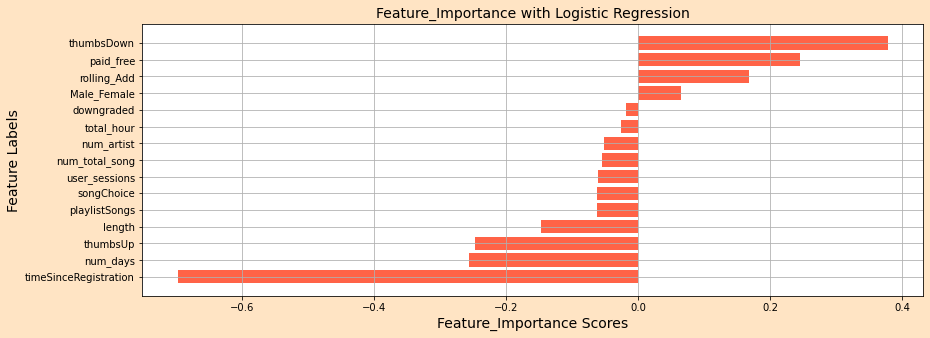

In [261]:
fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='bisque')
plt.barh(range(len(features_indices)), coeff_ratings[features_indices],
       color="tomato", align="center")
plt.grid()
plt.title("Feature_Importance with Logistic Regression", fontsize=14)
plt.xlabel("Feature_Importance Scores",fontsize=14)
plt.ylabel("Feature Labels", fontsize=14)
plt.yticks(range(len(features_indices)), final_dataSet_columns[features_indices])
plt.show()

#### 2. `LINEAR SUPPORT VECTOR CLASSIFICATION:`

In [215]:
clf_SVC = LinearSVC()
# Grid serach of SVM
paramGrid = ParamGridBuilder().\
            addGrid(clf_SVC.maxIter, [50, 100, 700]).\
            addGrid(clf_SVC.regParam, [0.01, 0.1, 10.0, 100.0]).\
            build()

# Cross validation of SVM
Crossval_SVC = CrossValidator(estimator = clf_SVC,
                      estimatorParamMaps=paramGrid,
                      evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                      numFolds=3)

In [216]:
# training the model
import time
start = time.time()
model_SVC = Crossval_SVC.fit(df_train)
end = time.time()
print(f'LinearSVC() model tuning is done with "training data" total time required: {end-start} seconds.')

LinearSVC() model tuning is done with "training data" total time required: 25733.523796081543 seconds.


In [217]:
# list of the metrics
model_SVC.avgMetrics

[0.7276647921126765,
 0.744865674480279,
 0.3733802347288717,
 0.3733802347288717,
 0.7348286346461002,
 0.744865674480279,
 0.3733802347288717,
 0.3733802347288717,
 0.7348286346461002,
 0.744865674480279,
 0.3733802347288717,
 0.3733802347288717]

In [220]:
# Hyperparameters of the best performing model
for key, value in model_SVC.getEstimatorParamMaps()[np.argmax(model_SVC.avgMetrics)].items():
    print(f'{key}: {value}')

LinearSVC_3ce210703e76__maxIter: 50
LinearSVC_3ce210703e76__regParam: 0.1


`TEST SET EVALUATION and CONFUSION MATRIX`

In [218]:
SVC_pred_test = model_SVC.transform(df_test)
SVC_pred_test.show(3)

+-----+--------------------+--------------------+----------+
|label|            features|       rawPrediction|prediction|
+-----+--------------------+--------------------+----------+
|    1|[-1.0762390990345...|[-0.5711331273151...|       1.0|
|    1|[-1.0762390990345...|[-3.8924210598095...|       1.0|
|    1|[0.92503195288915...|[0.10551056733071...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 3 rows



In [219]:
print('Test_set Accuracy Score with Linear SVC: ', accuracy_evaluator.evaluate(SVC_pred_test))
print('Test_set F1-Score with Linear SVC: ', f1_evaluator.evaluate(SVC_pred_test))

Test_set Accuracy Score with Linear SVC:  0.7647058823529411
Test_set F1-Score with Linear SVC:  0.7509803921568627


In [221]:
model_classification_scores(SVC_pred_test)

Model evaluation metric:
	 test_Set Accuracy 0.7647058823529411
	 test_Set precision:  0.75
	 test_Set Recall:  0.5
Confusion matrix
          Churned  Remained
Churned         3         1
Remained        3        10


`CONFUSION MATRIX ANALYSIS:`

- We have total 17 clients(test set) out of 52 total. 
- The classifier predicted 6 churned and 11 remained.
- In actuality we have 4 churned and 13 remained.
- Our type I error(False positive) 1 and type II error(Flase negative) is 3.

Here `precision`(0.75) is higher than `recall`(0.5) rate means higher number of `False Negative(3)` values. In our case cost associated with `FN` is more than `FP` rate. Having a higher `FN value` is not a good performance for us here. Also our accuracy rate 0.76 which is not a highly improved number.

`FEATURE IMPORTANCE WITH TRAINING SET:`

In [222]:
# empty dictionary
SVC_feature_importance = {}
# SVC model coefficient in array
coefficient_importance = model_SVC.bestModel.coefficients.toArray()
# returns indices of the feature arrays
feature_coefficient_importance = np.argsort(coefficient_importance)

# looping through the coefficient arrays
for k in feature_coefficient_importance:
    SVC_feature_importance[int(k)] = coefficient_importance[int(k)]

print("Features in decreasing order of importance: " )
sorted(SVC_feature_importance.values(), reverse=True)

Features in decreasing order of importance: 


[0.5735306469003342,
 0.29491594953040784,
 0.12754219796374158,
 0.023083983094477806,
 -0.003983469252708626,
 -0.026042472101312036,
 -0.03225610397048517,
 -0.04096294714004045,
 -0.043172327846625835,
 -0.046569067646519934,
 -0.09524179930665513,
 -0.17976811498897283,
 -0.32516465558663565,
 -0.3735226545361331,
 -0.8475565288222667]

In [251]:
# finding the range of coefficients of the log-reg model converting them to array
coeff_ratings = model_SVC.bestModel.coefficients.toArray()

# sorting the coefficients by order
features_indices = np.argsort(coeff_ratings)

# finding features name array
final_dataSet_columns = np.array(final_dataSet_columns)

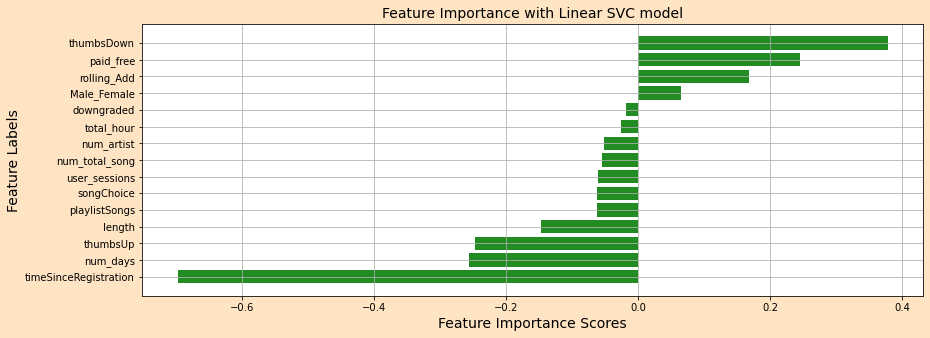

In [262]:
fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='bisque')
plt.barh(range(len(features_indices)), coeff_ratings[features_indices],
       color="forestgreen", align="center")
plt.grid()
plt.title('Feature Importance with Linear SVC model', fontsize=14)
plt.xlabel("Feature Importance Scores",fontsize=14)
plt.ylabel("Feature Labels", fontsize=14)
plt.yticks(range(len(features_indices)), final_dataSet_columns[features_indices])
plt.show()

#### 3. `RANDOM FOREST CLASSIFIER:`

In [225]:
# grid-search
paramGrid = ParamGridBuilder() \
            .addGrid(clf_RF.impurity,['entropy', 'gini']) \
            .addGrid(clf_RF.maxDepth,[5, 10]) \
            .addGrid(clf_RF.seed, [42]).build()

In [226]:
# cross-validation
crossval_RF = CrossValidator(estimator=clf_RF,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(),
                    numFolds=3)

In [227]:
# train
start = time.time()
RF_model = crossval_RF.fit(df_train)
end = time.time()
print(f'Random Forest Model tuning with "training data" is done, spent: {end-start} seconds.')

Random Forest Model tuning with "training data" is done, spent: 2592.6374423503876 seconds.


In [228]:
# evaluate list of metric
RF_model.avgMetrics

[0.6078045292062572,
 0.6199771669411138,
 0.6940582536078905,
 0.6690455513984925]

In [229]:
# Hyperparameters of the best performing model
for key, value in RF_model.getEstimatorParamMaps()[np.argmax(RF_model.avgMetrics)].items():
    print(f'{key}: {value}')

RandomForestClassifier_26d4842b76e2__impurity: gini
RandomForestClassifier_26d4842b76e2__maxDepth: 5
RandomForestClassifier_26d4842b76e2__seed: 42


`TEST SET EVALUATION and CONFUSION MATRIX`

In [230]:
RF_pred_test = RF_model.transform(df_test)
RF_pred_test.show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[-1.0762390990345...|[3.96890715350467...|[0.39689071535046...|       1.0|
|    1|[-1.0762390990345...|[5.98133116883116...|[0.59813311688311...|       0.0|
|    1|[0.92503195288915...|[7.38267543859649...|[0.73826754385964...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [231]:
print('Test_set Accuracy score with Random Forest model: ', accuracy_evaluator.evaluate(RF_pred_test) )
print('Test_set f1 score with Random Forest model: ', f1_evaluator.evaluate(RF_pred_test))

Test_set Accuracy score with Random Forest model:  0.47058823529411764
Test_set f1 score with Random Forest model:  0.478345184227537


In [232]:
# transforming test dataset
model_classification_scores(RF_pred_test)

Model evaluation metric:
	 test_Set Accuracy 0.47058823529411764
	 test_Set precision:  0.2857142857142857
	 test_Set Recall:  0.3333333333333333
Confusion matrix
          Churned  Remained
Churned         2         5
Remained        4         6


`CONFUSION MATRIX ANALYSIS:`

- We have total 17 clients(test set) out of 52 total. 
- The classifier predicted 6 churned and 11 remained.
- In actuality we have 7 churned and 10 remained.
- Our type I error(False positive) 5 and type II error(Flase negative) is 4 a bigger number comparatively.

Here `precision`(0.28) is lower than `recall`(0.33) rate means higher number of `False Positive(5)` values. In our case cost associated with `FN` is more than `FP` rate. Also our accuracy rate 0.47 is way lower than other two algorithms.

`FEATURE IMPORTANCE WITH TRAINING DATASET`

In [233]:
RF_feature_importance = {}
feature_importance = RF_model.bestModel.featureImportances
for k in feature_importance.indices:
    RF_feature_importance[int(k)] = feature_importance[int(k)]
print('RF model feature importance decreasig order: ')    
sorted(RF_feature_importance.values(), reverse=True)

RF model feature importance decreasig order: 


[0.2267625083316572,
 0.1268889641855206,
 0.12668708803259324,
 0.12387373168352141,
 0.07312483723512596,
 0.06080146416118844,
 0.055552250843109455,
 0.04535740976122087,
 0.04531856279607863,
 0.04392585436483098,
 0.019921185689564906,
 0.0169157607717078,
 0.01679060053260769,
 0.009654425145940258,
 0.0084253564653326]

In [265]:
# finding the range of coefficients of the log-reg model converting them to array
features_ratings = RF_model.bestModel.featureImportances.toArray()

# sorting the coefficients by order
features_indices = np.argsort(features_ratings)

# finding features name array
final_dataSet_columns = np.array(final_dataSet_columns)

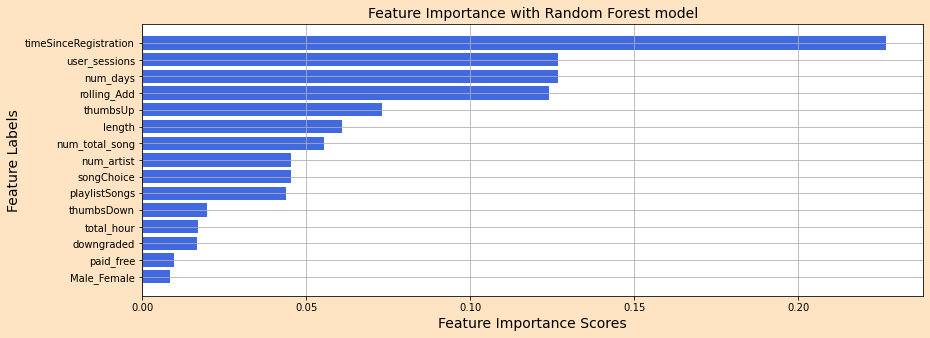

In [268]:
fig, ax = plt.subplots(figsize=(14, 5), edgecolor='k', facecolor='bisque')
plt.barh(range(len(features_indices)), features_ratings[features_indices],
       color="royalblue", align="center")

plt.grid()
plt.title('Feature Importance with Random Forest model', fontsize=14)
plt.xlabel("Feature Importance Scores",fontsize=14)
plt.ylabel("Feature Labels", fontsize=14)
plt.yticks(range(len(features_indices)), final_dataSet_columns[features_indices])
plt.show()

In [270]:
# Grabbing the best estimator's feature_importances_
#importances = RF_model.bestModel.featureImportances.toArray()

# Grabbing the indices that would sort the feature importances according to their importance rating
#indices = np.argsort(importances)

# Creating a features array
#final_dataSet_columns = np.array(final_dataSet_columns)

# Plotting
#plt.figure(figsize=(12,5))
#plt.title("Feature Importances")
#plt.barh(range(len(indices)), importances[indices],
#       color="peru", align="center")
#plt.yticks(range(len(indices)), final_dataSet_columns[indices])
#plt.show()

####  4. `DECISION TREE CLASSIFIER`

In [236]:
clf_DT = DecisionTreeClassifier() #(seed=40)
# Grid serach of Decision tree
paramGrid = ParamGridBuilder() \
    .addGrid(clf_DT.impurity,['entropy', 'gini']) \
    .addGrid(clf_DT.maxDepth,[2, 4])\
    .addGrid(clf_DT.seed, [42])\
    .build()

# Cross validation of dt
crossval_DT = CrossValidator(estimator=clf_DT,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [237]:
# training the model
#import time
start = time.time()
model_DT = crossval_DT.fit(df_train)
end = time.time()
print(f'Model tuning is done and time spent: {end-start}s.')

Model tuning is done and time spent: 2474.098781108856s.


In [238]:
model_DT.avgMetrics

[0.7512236842865645,
 0.6059160858269843,
 0.7198103639280109,
 0.6427050699247188]

In [239]:
# Hyperparameters of the best performing model
for key, value in model_DT.getEstimatorParamMaps()[np.argmax(model_DT.avgMetrics)].items():
    print(f'{key}: {value}')

DecisionTreeClassifier_a4b724860baf__impurity: entropy
DecisionTreeClassifier_a4b724860baf__maxDepth: 2
DecisionTreeClassifier_a4b724860baf__seed: 42


`TEST SET EVALUATION and CONFUSION MATRIX`

In [240]:
DT_pred_test = model_DT.transform(df_test)
DT_pred_test.show(3)

+-----+--------------------+-------------+--------------------+----------+
|label|            features|rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+----------+
|    1|[-1.0762390990345...|   [7.0,31.0]|[0.18421052631578...|       1.0|
|    1|[-1.0762390990345...|   [7.0,31.0]|[0.18421052631578...|       1.0|
|    1|[0.92503195288915...|  [34.0,15.0]|[0.69387755102040...|       0.0|
+-----+--------------------+-------------+--------------------+----------+
only showing top 3 rows



In [241]:
#DT_test_accuracy = accuracy_evaluator.evaluate(DT_pred_test)  
#DT_test_f1 = f1_evaluator.evaluate(DT_pred_test)
print('Test_set Accuracy with Decision Tree model: ', accuracy_evaluator.evaluate(DT_pred_test) )
print('Test_set F1-score with Decision Tree model: ', f1_evaluator.evaluate(DT_pred_test))

Test_set Accuracy with Decision Tree model:  0.6470588235294118
Test_set F1-score with Decision Tree model:  0.6470588235294118


In [242]:
model_classification_scores(DT_pred_test)

Model evaluation metric:
	 test_Set Accuracy 0.6470588235294118
	 test_Set precision:  0.5
	 test_Set Recall:  0.5
Confusion matrix
          Churned  Remained
Churned         3         3
Remained        3         8


`CONFUSION MATRIX ANALYSIS:`

- We have total 17 clients(test set) out of 52 total. 
- The classifier predicted 6 churned and 11 remained.
- In actuality we have 6 churned and 11 remained.
- Our type I error(False positive) 3 and type II error(Flase negative) is 3 is equal number.

Here `precision`(0.50) is equal to `recall`(0.50) rate and evidently our `False Positive(3)` is equal to `False Negative(3)` values. Our accuracy rate is 0.64 and overall performance is slightly improved than Random Forest mdoel but not worthy of persuasion.

`FEATURE IMPORTANCE WITH TRAINING SET`

In [243]:
model_DT.bestModel.featureImportances

SparseVector(15, {3: 1.0})

In [244]:
# finding the range of coefficients of the log-reg model converting them to array
feature_ratings = model_DT.bestModel.featureImportances.toArray()

# sorting the coefficients by order
features_indices = np.argsort(feature_ratings)

# finding features name array
final_dataSet_columns = np.array(final_dataSet_columns)

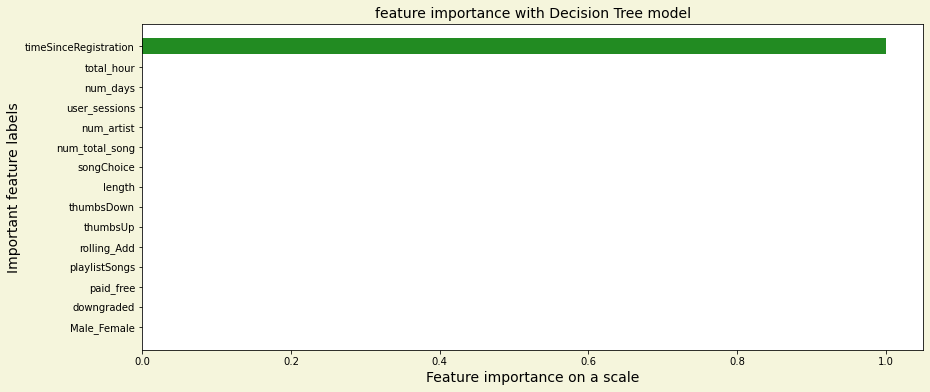

In [245]:
fig, ax = plt.subplots(figsize=(14, 6), edgecolor='k', facecolor='beige')
plt.barh(range(len(features_indices)), feature_ratings[features_indices],
       color="forestgreen", align="center")

plt.title('feature importance with Decision Tree model', fontsize=14)
plt.xlabel("Feature importance on a scale",fontsize=14)
plt.ylabel("Important feature labels", fontsize=14)
plt.yticks(range(len(features_indices)), final_dataSet_columns[features_indices])
plt.show()

### `Conclusion: ` 
It's been a journey with PySpark as I was using my desktop doing parametric computation. It's been a time ridden experience overall and I'd say using 'PySpark' intensive computation with local machine is a terrible idea. I had to navigate github, google search in extraordinary way to come this end of this project, an experience!

- I found Logistic Regression and Linear Support Vector Classification algorithm performs best among all the algorithms I've tried. But timing with LSVC is higher than Logistic regression with minimum performance gain.

- In all considerations Logistic Regression is a better choice algorithm for us here.

- The feature importance result was almost identical in both algorithms.

- On feature importance I think negatively correlated features hold importance for the 'Not Churned' users mostly.

- Feature engineering aspect has immense possibility of redefining the model performance.

`Type I and II errors: Notes `
- `Type I error (False Positive)` refers to non-acceptance of hypothesis which ought to be accepted. By and large, Type I error crops up when the researcher notice some difference, when in fact, there is none. `So we should accept the false-positive values.`

- `Type II error (False Negative)`is the acceptance of hypothesis which ought to be rejected. whereas type II error arises when the researcher does not discover any difference when in truth there is one. `We should reject the false-negative values.`

- These two errors cannot be removed completely but can be reduced to a certain level.

## References: 

`1`: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/

`2.`: https://github.com/CapAllen/Sparkify/blob/master/Sparkify.ipynb

`3`: https://github.com/ustcdj/Sparkify_Churn_Analysis/blob/master/Sparkify.ipynb

`4`:https://www.dummies.com/education/math/statistics/how-to-set-up-a-hypothesis-test-null-versus-alternative/